# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

In [2]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA 
#from sklearn.impute import SimpleImputer
import sklearn
sklearn.__version__

'0.19.1'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print("AZDIAS DATASET",azdias.shape)
azdias.head()


AZDIAS DATASET (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
print("FEATURE SUMMARY",feat_info.shape)
feat_info.head()

FEATURE SUMMARY (85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
#additional missing values 
addtnl_unknown_vals = feat_info.missing_or_unknown.unique()
#naturally missing values from azdias
natural_NaN_vals = azdias.isnull().sum().sum()
#naturally missing values per col from azdias 
natural_NaN_per_col = azdias.isnull().sum()
print("Total no.of naturally missing NaN values are:", natural_NaN_vals)
print("Unique missing/unknown values look like:", addtnl_unknown_vals)

Total no.of naturally missing NaN values are: 4896838
Unique missing/unknown values look like: ['[-1,0]' '[-1,0,9]' '[0]' '[-1]' '[]' '[-1,9]' '[-1,X]' '[XX]' '[-1,XX]']


In [7]:
# Parsing the missing/unknown value information from feat_info summary 
def clean_alt_list(list_): 
    list_ = list_.strip('[]').split(',\s*')[0].split(',')
    if (len(list_)==1 and list_[0] == ''):
        return []
    else:
        list_ = [eval(e) if e.strip('-').isnumeric() else e for e in list_]
        return list_

modified_feat_info = feat_info.copy() #creating a copy of original feature info summary
modified_feat_info.missing_or_unknown = modified_feat_info.missing_or_unknown.apply(clean_alt_list)
missing_data_encode = dict(zip(modified_feat_info.attribute, modified_feat_info.missing_or_unknown))

In [8]:
print(missing_data_encode)

{'AGER_TYP': [-1, 0], 'ALTERSKATEGORIE_GROB': [-1, 0, 9], 'ANREDE_KZ': [-1, 0], 'CJT_GESAMTTYP': [0], 'FINANZ_MINIMALIST': [-1], 'FINANZ_SPARER': [-1], 'FINANZ_VORSORGER': [-1], 'FINANZ_ANLEGER': [-1], 'FINANZ_UNAUFFAELLIGER': [-1], 'FINANZ_HAUSBAUER': [-1], 'FINANZTYP': [-1], 'GEBURTSJAHR': [0], 'GFK_URLAUBERTYP': [], 'GREEN_AVANTGARDE': [], 'HEALTH_TYP': [-1, 0], 'LP_LEBENSPHASE_FEIN': [0], 'LP_LEBENSPHASE_GROB': [0], 'LP_FAMILIE_FEIN': [0], 'LP_FAMILIE_GROB': [0], 'LP_STATUS_FEIN': [0], 'LP_STATUS_GROB': [0], 'NATIONALITAET_KZ': [-1, 0], 'PRAEGENDE_JUGENDJAHRE': [-1, 0], 'RETOURTYP_BK_S': [0], 'SEMIO_SOZ': [-1, 9], 'SEMIO_FAM': [-1, 9], 'SEMIO_REL': [-1, 9], 'SEMIO_MAT': [-1, 9], 'SEMIO_VERT': [-1, 9], 'SEMIO_LUST': [-1, 9], 'SEMIO_ERL': [-1, 9], 'SEMIO_KULT': [-1, 9], 'SEMIO_RAT': [-1, 9], 'SEMIO_KRIT': [-1, 9], 'SEMIO_DOM': [-1, 9], 'SEMIO_KAEM': [-1, 9], 'SEMIO_PFLICHT': [-1, 9], 'SEMIO_TRADV': [-1, 9], 'SHOPPER_TYP': [-1], 'SOHO_KZ': [-1], 'TITEL_KZ': [-1, 0], 'VERS_TYP': [-1], 

#### _Identify missing or unknown data values and convert them to NaNs._
- Preprocessing the *AZDIAS* dataset & finding the actual no.of missing/unknown values after the additional values picked from the column from *feat_info* summary dataset are replaced by NaN

In [9]:
#convert to a dataframe - to create a new azdias dataframe that will hold the additional missing/unknown values
modified_azdias = azdias.copy() 

#Check if any value from any cell for a given column in AZDIAS dataset is present in the list of
#additional missing or unknown values from the feat_info summary 'missing_or_unknown' column. If yes, replace it with np.nan
for col in missing_data_encode.keys():
    modified_azdias.loc[modified_azdias[col].isin(missing_data_encode[col]), col] = np.nan

modified_azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [10]:
#print actual NaN vals 
actual_NaN_vals = modified_azdias.isnull().sum().sum()
actual_NaN_per_col = modified_azdias.isnull().sum()
print("Total no.of NaN values after factoring in the additional unknown/missing values:", actual_NaN_vals)

Total no.of NaN values after factoring in the additional unknown/missing values: 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

#### _Perform an assessment of how much missing data there is in each column of the dataset._

In [11]:
azdias_NaNcol_before = pd.DataFrame({'attributes' : feat_info.attribute.tolist(), \
                             'BEFORE addtnl miss_unknown vals': natural_NaN_per_col.tolist(), \
                             '%NaN_per_attri_before_pp': round(azdias.isnull().sum()/azdias.shape[0]*100,2).tolist()})
azdias_NaNcol_before.head()

,attributes,BEFORE addtnl miss_unknown vals,%NaN_per_attri_before_pp
0,AGER_TYP,0,0.00
1,ALTERSKATEGORIE_GROB,0,0.00
2,ANREDE_KZ,0,0.00
3,CJT_GESAMTTYP,4854,0.54
4,FINANZ_MINIMALIST,0,0.00


Top 10 attributes with highest %samples having NaN values BEFORE preprocessing:


,attributes,BEFORE addtnl miss_unknown vals,%NaN_per_attri_before_pp
47,KK_KUNDENTYP,584612,65.60
65,KBA05_GBZ,133324,14.96
60,KBA05_ANTG1,133324,14.96
62,KBA05_ANTG3,133324,14.96
71,MOBI_REGIO,133324,14.96
61,KBA05_ANTG2,133324,14.96
63,KBA05_ANTG4,133324,14.96
64,KBA05_BAUMAX,133324,14.96
73,REGIOTYP,121196,13.60
70,KKK,121196,13.60


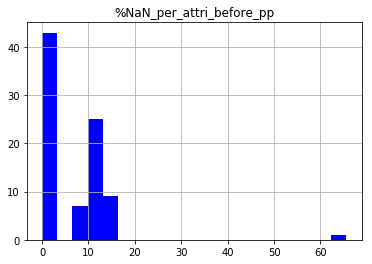

In [12]:
colhist_before = azdias_NaNcol_before.hist(column='%NaN_per_attri_before_pp', bins=20, sharey=True, color='b')
perc_nan_attr_before = azdias_NaNcol_before.sort_values(by=['%NaN_per_attri_before_pp'], ascending=False)
print("Top 10 attributes with highest %samples having NaN values BEFORE preprocessing:")
perc_nan_attr_before.head(10)

#### *Investigate patterns in the amount of missing data in each column*
 - ***Part-1:*** Finding the % of samples having NaN values per attribute after preprocessing the dataset adding new col: **%NaN_per_attri_after_pp**

In [13]:
azdias_NaNcol_after = pd.DataFrame({'attributes' : feat_info.attribute.tolist(), \
                             'AFTER addtnl miss_unknown vals': actual_NaN_per_col.tolist(), \
                             '%NaN_per_attri_after_pp': round(modified_azdias.isnull().mean()*100,2).tolist()})#round(modified_azdias.isnull().sum()/modified_azdias.shape[0]*100,2).tolist()})
azdias_NaNcol_after.head()

,attributes,AFTER addtnl miss_unknown vals,%NaN_per_attri_after_pp
0,AGER_TYP,685843,76.96
1,ALTERSKATEGORIE_GROB,2881,0.32
2,ANREDE_KZ,0,0.00
3,CJT_GESAMTTYP,4854,0.54
4,FINANZ_MINIMALIST,0,0.00


- ***Part-2:*** Plotting a histo chart on no. of features having different %NaN values calculated per feature after preprocessing

Top 10 attributes with highest %samples having NaN values AFTER preprocessing:
        attributes  AFTER addtnl miss_unknown vals  %NaN_per_attri_after_pp
40        TITEL_KZ                          889061                    99.76
0         AGER_TYP                          685843                    76.96
47    KK_KUNDENTYP                          584612                    65.60
64    KBA05_BAUMAX                          476524                    53.47
11     GEBURTSJAHR                          392318                    44.02
43        ALTER_HH                          310267                    34.81
70             KKK                          158064                    17.74
73        REGIOTYP                          158064                    17.74
48  W_KEIT_KIND_HH                          147988                    16.61
60     KBA05_ANTG1                          133324                    14.96


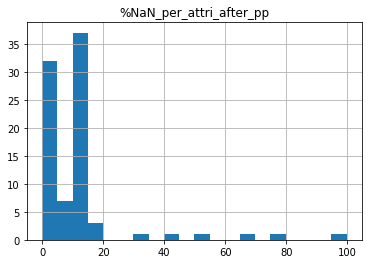

In [14]:
colhist_after = azdias_NaNcol_after.hist(column='%NaN_per_attri_after_pp', bins=20, sharey=True)
perc_nan_attr_after = azdias_NaNcol_after.sort_values(by=['%NaN_per_attri_after_pp'], ascending=False)
print("Top 10 attributes with highest %samples having NaN values AFTER preprocessing:", perc_nan_attr_after.head(10), sep='\n')

- ***Part-3:*** Comparing the no.of features or attributes with NaN values before & after encoding the missing values

In [15]:
zero_NaN_after_pp = len(azdias_NaNcol_after[azdias_NaNcol_after['%NaN_per_attri_after_pp']==0.00]) #24 features dont have NaN
zero_NaN_before_pp = len(azdias_NaNcol_before[azdias_NaNcol_before['%NaN_per_attri_before_pp']==0.00]) 
print("No.of attributes having 0 NaN values across all samples before preprocessing = ", zero_NaN_before_pp)
print("%of attributes with 0 NaN values for all samples before preprocessing = ", \
      round(zero_NaN_before_pp/azdias_NaNcol_before.shape[0]*100,2))
print("No.of attributes having 0 NaN values across all samples after preprocessing = ", zero_NaN_after_pp)
print("%of attributes with 0 NaN values for all samples after preprocessing = ", \
      round(zero_NaN_after_pp/azdias_NaNcol_after.shape[0]*100,2))

#no.of attributes no change before & after preprocessing & what are they ?
df_nochange = azdias_NaNcol_after[azdias_NaNcol_after['%NaN_per_attri_after_pp'].eq(azdias_NaNcol_before['%NaN_per_attri_before_pp'])]
print("No. of attributes not affected by preprocessing:",df_nochange.shape[0])
print("%attributes not affected by preprocessing:",round(df_nochange.shape[0]/azdias_NaNcol_after.shape[0]*100,2))
df_nochange.head(10)

No.of attributes having 0 NaN values across all samples before preprocessing =  32
%of attributes with 0 NaN values for all samples before preprocessing =  37.65
No.of attributes having 0 NaN values across all samples after preprocessing =  24
%of attributes with 0 NaN values for all samples after preprocessing =  28.24
No. of attributes not affected by preprocessing: 61
%attributes not affected by preprocessing: 71.76


,attributes,AFTER addtnl miss_unknown vals,%NaN_per_attri_after_pp
2,ANREDE_KZ,0,0.00
3,CJT_GESAMTTYP,4854,0.54
4,FINANZ_MINIMALIST,0,0.00
5,FINANZ_SPARER,0,0.00
6,FINANZ_VORSORGER,0,0.00
7,FINANZ_ANLEGER,0,0.00
8,FINANZ_UNAUFFAELLIGER,0,0.00
9,FINANZ_HAUSBAUER,0,0.00
10,FINANZTYP,0,0.00
12,GFK_URLAUBERTYP,4854,0.54


#### *Remove the outlier columns from the dataset. (You'll perform other data engineering tasks such as re-encoding and imputation later).*
- Creating a function that filters out columns based on the %NaN values per column
- Different concentration levels are assigned depending on the %NaN:
  - If **%NaN=0%** --> Concentration level = **zero**
  - If **%NaN<=10%** --> Concentration level = **low**
  - If **%NaN<=30%** --> Concentration level = **medium** 
  - If **%NaN>30%** --> Concentration level = **high**
- The goal is to identify & drop those columns which are having maximum, i.e high concentration of NaN values

In [16]:
def assign_NaNcliff_col(col_perc_):
    if col_perc_ == 0.0: return 'zero'
    elif col_perc_ <= 10.0:return 'low'
    elif col_perc_ <= 30: return 'medium'
    else: return 'high'

azdias_NaNcol_after['NaN_conc_col'] = azdias_NaNcol_after['%NaN_per_attri_after_pp'].apply(assign_NaNcliff_col)
azdias_NaNcol_after.head()

,attributes,AFTER addtnl miss_unknown vals,%NaN_per_attri_after_pp,NaN_conc_col
0,AGER_TYP,685843,76.96,high
1,ALTERSKATEGORIE_GROB,2881,0.32,low
2,ANREDE_KZ,0,0.00,zero
3,CJT_GESAMTTYP,4854,0.54,low
4,FINANZ_MINIMALIST,0,0.00,zero


In [17]:
high_NaN_cols = azdias_NaNcol_after.loc[azdias_NaNcol_after['NaN_conc_col'] == 'high', 'attributes'].tolist()
medium_NaN_cols = azdias_NaNcol_after.loc[azdias_NaNcol_after['NaN_conc_col'] == 'medium', 'attributes'].tolist()
low_NaN_cols = azdias_NaNcol_after.loc[azdias_NaNcol_after['NaN_conc_col'] == 'low', 'attributes'].tolist()
zero_NaN_cols = azdias_NaNcol_after.loc[azdias_NaNcol_after['NaN_conc_col'] == 'zero', 'attributes'].tolist()
print(f'{len(high_NaN_cols)} features have high or >30% samples with NaN values which are {high_NaN_cols}')
print(f'{len(medium_NaN_cols)} features have medium level or >10-30% samples with NaN values')
print(f'{len(low_NaN_cols)} features have low or >0-10% samples with NaN values')
print(f'{len(zero_NaN_cols)} features do not have any sample with NaN values')

6 features have high or >30% samples with NaN values which are ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
40 features have medium level or >10-30% samples with NaN values
15 features have low or >0-10% samples with NaN values
24 features do not have any sample with NaN values


#### *%NaN concentration levels per col by information_level*

In [18]:
feat_info_NaN_conc = feat_info.copy()
feat_info_NaN_conc['%NaN_level_col'] = azdias_NaNcol_after['NaN_conc_col'].tolist()
feat_info_NaN_conc['perc_val_NaN_col'] = azdias_NaNcol_after['%NaN_per_attri_after_pp'].tolist()
feat_info_NaN_conc.head()

,attribute,information_level,type,missing_or_unknown,%NaN_level_col,perc_val_NaN_col
0,AGER_TYP,person,categorical,"[-1,0]",high,76.96
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]",low,0.32
2,ANREDE_KZ,person,categorical,"[-1,0]",zero,0.00
3,CJT_GESAMTTYP,person,categorical,[0],low,0.54
4,FINANZ_MINIMALIST,person,ordinal,[-1],zero,0.00


Text(0.5,1,'%NaN concentration distribution by information level')

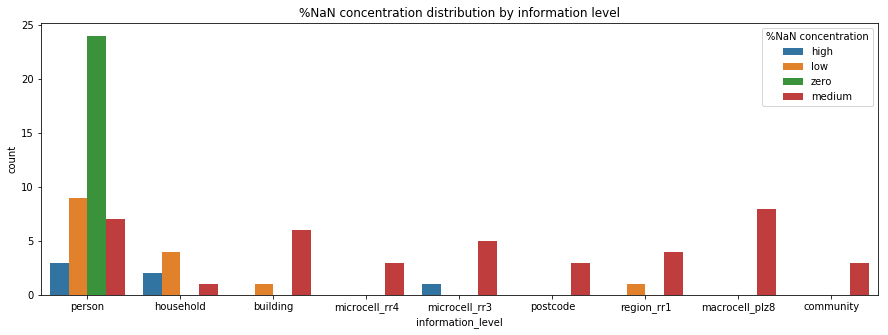

In [19]:
dims_1 = (15,5)
fig_c1, ax_c1 = plt.subplots(figsize = dims_1)
ax_col1 = sns.countplot(x = "information_level", hue = "%NaN_level_col", orient = "v", ax = ax_c1, data = feat_info_NaN_conc)
plt.legend(loc='upper right', title='%NaN concentration')
plt.title('%NaN concentration distribution by information level')

#### *Drop columns with high %NaN values across all samples as they are the outliers*

In [20]:
feat_info_NaN_conc[feat_info_NaN_conc['%NaN_level_col'] == 'high']

,attribute,information_level,type,missing_or_unknown,%NaN_level_col,perc_val_NaN_col
0,AGER_TYP,person,categorical,"[-1,0]",high,76.96
11,GEBURTSJAHR,person,numeric,[0],high,44.02
40,TITEL_KZ,person,categorical,"[-1,0]",high,99.76
43,ALTER_HH,household,interval,[0],high,34.81
47,KK_KUNDENTYP,household,categorical,[-1],high,65.60
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]",high,53.47


In [21]:
cols_to_drop = feat_info_NaN_conc[feat_info_NaN_conc['%NaN_level_col'] == 'high'].attribute
print("Columns to be removed:", cols_to_drop.tolist())

Columns to be removed: ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [22]:
#refined_azdias is the new dataframe after high NaN cols are dropped as they are outliers
refined_azdias = modified_azdias.drop(columns = cols_to_drop)
refined_azdias.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

From the bar graph, following are the observations:
1. Only 6 features (aka attributes) have >30% samples with NaN values:
  - they are: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX'. 
  - 3 features belong to "person", 2 features are from "household" while only 1 feature is from "microcel_rr3" information levels.
2. 40 features have >10% but atmost 30% of samples with NaN values
3. 39 features have atmost 10% samples with NaN values , out of which 24 features (all belonging to 'person' information_level) do not have any sample with NaN values
4. The 'person' information level is the most uniformly distributed, followed by 'household' information level.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

#### *How much data is missing in each row of the dataset?*
- Use the new dataset which has dropped the outlier columns from step1.1.2
- ***Part-1:*** Create a function to identify rows with different %NaN per row & assign respective concentration levels as below:
  - If **%NaN=0%** --> Concentration level = **zero**
  - If **%NaN<=10%** --> Concentration level = **low**
  - If **%NaN<=30%** --> Concentration level = **medium** 
  - If **%NaN>30%** --> Concentration level = **high**

In [23]:
azdias_NaNrow_after = refined_azdias.copy()
azdias_NaNrow_after['NaN_per_row_after_pp'] = refined_azdias.isnull().sum(axis=1)
azdias_NaNrow_after.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NaN_per_row_after_pp
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0


In [24]:
azdias_NaNrow_after['perc_NaN_per_row_after_pp'] = round(refined_azdias.isnull().mean(axis=1)*100,2)
azdias_NaNrow_after.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NaN_per_row_after_pp,perc_NaN_per_row_after_pp
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,54.43
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0.00
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0.00
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7,8.86
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0.00


In [25]:
def assign_NaNcliff_row(row_):
    if row_ == 0.0: return 'zero'
    elif row_ <= 10.0:return 'low'
    elif row_ <= 30.0: return 'medium'
    else: return 'high'
    
#get/assign concentration level per row
azdias_NaNrow_after['NaN_conc_row'] = azdias_NaNrow_after.perc_NaN_per_row_after_pp.apply(assign_NaNcliff_row)
azdias_NaNrow_after.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NaN_per_row_after_pp,perc_NaN_per_row_after_pp,NaN_conc_row
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43,54.43,high
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0,0.00,zero
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0,0.00,zero
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,0.0,1.0,3.0,4.0,2.0,3.0,3.0,7,8.86,low
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0,0.00,zero


#### *Part-2: Get the summary of no.of samples having different %NaN values per row & plot the distribution*

In [26]:
num_high_NaN_row = len(azdias_NaNrow_after[azdias_NaNrow_after['NaN_conc_row'] == 'high'])
num_low_NaN_row = len(azdias_NaNrow_after[azdias_NaNrow_after['NaN_conc_row'] == 'low'])
num_medium_NaN_row = len(azdias_NaNrow_after[azdias_NaNrow_after['NaN_conc_row'] == 'medium'])
num_zero_NaN_row = len(azdias_NaNrow_after[azdias_NaNrow_after['NaN_conc_row'] == 'zero'])
total_samples = azdias_NaNrow_after.shape[0]
print(f'{num_zero_NaN_row} samples do NOT have NaN value at any attribute, \n{num_low_NaN_row} \
samples have >0-10% NaN values per row,\n{num_medium_NaN_row} \
samples have >10-30% NaN values per row while\n{num_high_NaN_row} \
samples have >30% NaN values per row')

623209 samples do NOT have NaN value at any attribute, 
123900 samples have >0-10% NaN values per row,
50728 samples have >10-30% NaN values per row while
93384 samples have >30% NaN values per row


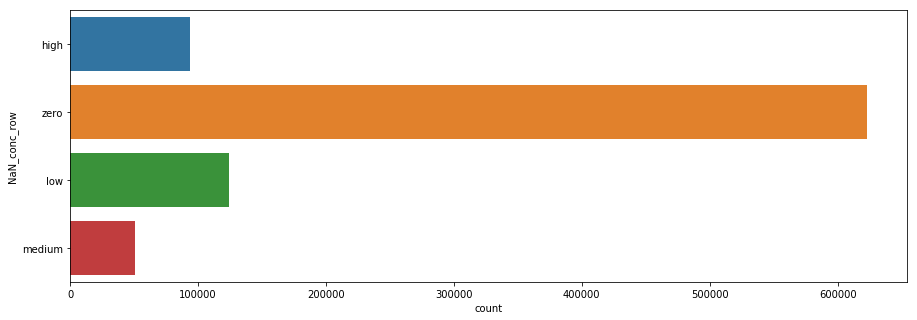

In [27]:
dims_r = (5,5)
fig_r, ax_r = plt.subplots(figsize = dims_1)
ax_row = sns.countplot(y ="NaN_conc_row", data = azdias_NaNrow_after, ax = ax_r)


Text(0,0.5,'No.of rows')

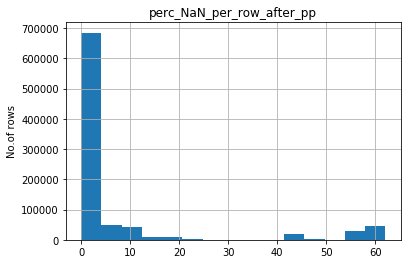

In [28]:
rowhist_perc = azdias_NaNrow_after.hist(column='perc_NaN_per_row_after_pp', bins = 15)
plt.ylabel("No.of rows")

#### *A function to divide the data into two subsets based on the number of missing values in each row.*
- Keeping 10% as the threshold to separate rows into 2 subsets: 
  - **Subset 0** = Rows with <=10% NaN values/row
  - **Subset 1** = Rows with >10% NaN values/row

In [29]:
threshold = 10.00  
def row_subset_threshold(row_):
    if row_ <= threshold: return 'Subset 0'
    else: return 'Subset 1'
    
azdias_NaNrow_after['Subset'] = azdias_NaNrow_after.perc_NaN_per_row_after_pp.apply(row_subset_threshold)
azdias_NaNrow_after.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NaN_per_row_after_pp,perc_NaN_per_row_after_pp,NaN_conc_row,Subset
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,43,54.43,high,Subset 1
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,1.0,5.0,4.0,3.0,5.0,4.0,0,0.00,zero,Subset 0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,1.0,4.0,4.0,3.0,5.0,2.0,0,0.00,zero,Subset 0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,1.0,3.0,4.0,2.0,3.0,3.0,7,8.86,low,Subset 0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,3.0,3.0,4.0,6.0,5.0,0,0.00,zero,Subset 0


In [30]:
subset0 = azdias_NaNrow_after.loc[azdias_NaNrow_after['Subset'] == 'Subset 0']
subset1 = azdias_NaNrow_after.loc[azdias_NaNrow_after['Subset'] == 'Subset 1']
print(f'Size of dataframe <=10% NaNs/row is {subset0.shape} & with >10% NaNs/row is {subset1.shape}')
print(f'{round(subset0.shape[0]/azdias_NaNrow_after.shape[0]*100,2)}% of rows with <=10% NaNs & {round(subset1.shape[0]/azdias_NaNrow_after.shape[0]*100,2)} \
% of rows with >10% NaNs')

Size of dataframe <=10% NaNs/row is (747109, 83) & with >10% NaNs/row is (144112, 83)
83.83% of rows with <=10% NaNs & 16.17 % of rows with >10% NaNs


In [31]:
#select columns with no NaNs from each of the subset (also drop redundant columns)
zero_nan_col_subset0 = subset0.dropna(axis=1).drop(columns=['NaN_per_row_after_pp','NaN_conc_row','Subset','perc_NaN_per_row_after_pp'])
print("Size of subset 0 having cols with NO NaNs:", zero_nan_col_subset0.shape)
zero_nan_col_subset1 = subset1.dropna(axis=1).drop(columns=['NaN_per_row_after_pp','NaN_conc_row','Subset','perc_NaN_per_row_after_pp'])
print("Size of subset 1 having cols with NO NaNs:", zero_nan_col_subset1.shape)

Size of subset 0 having cols with NO NaNs: (747109, 39)
Size of subset 1 having cols with NO NaNs: (144112, 24)


#### *Plot the distribution graphs of top 6 common features (having no NaN values throughout) from both the subsets & compare*

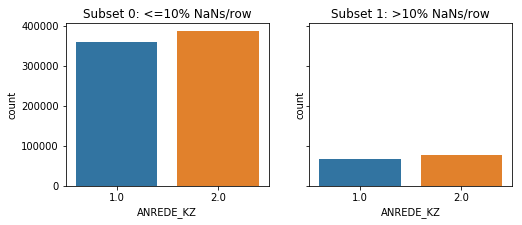

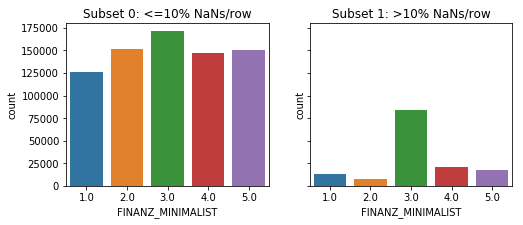

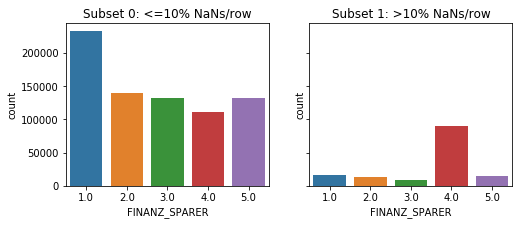

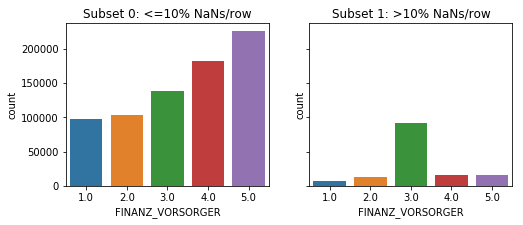

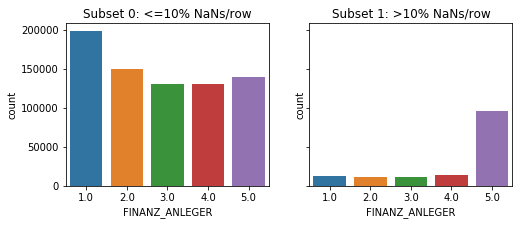

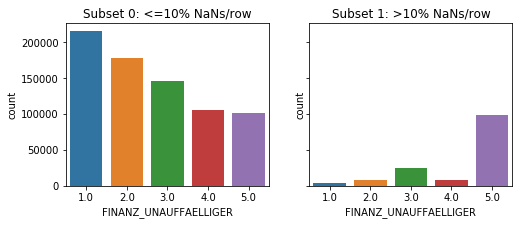

In [32]:
common_cols_zero_nan = list(zero_nan_col_subset0.columns.intersection(zero_nan_col_subset1.columns))
for col in common_cols_zero_nan[:6]:
    fig, ax_r = plt.subplots(1,2,figsize = (8,3),sharey=True)
    sns.countplot(subset0[col], ax = ax_r[0])
    ax_r[0].set_title('Subset 0: <=10% NaNs/row')
    sns.countplot(subset1[col], ax = ax_r[1])
    ax_r[1].set_title('Subset 1: >10% NaNs/row') 


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

- Once the high NaN columns are removed, total no.of rows (or samples) having zero NaN values are significantly high, comprising around ~6 lakhs samples 
- With threshold of 10% NaN values per row, 2 subsets are created with samples having <=10% NaN values per row as Subset 0 & those with >10% NaN values/row as Subset 1. 
- 83.83% of samples belong to subset 0 & only 16.17% of samples belong to subset 1, clearly showing a majority of rows(or samples) have only <=10% NaN values per sample
- Distribution of unique values across common columns with zero NaN values on subset 0 is significantly higher when compared to subset 1. 
- Hence, we should drop all the samples which are having lower distribution, i.e all the samples belonging to Subset 1 (i.e  rows with >10% NaN values) should be dropped from the dataset & not be considered for further data analysis

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

#### *Select the dataframe that has the least NaNs/row i.e <=10% i.e select subset-0 & proceed with further data analysis hereafter*

In [33]:
least_nan_df = azdias_NaNrow_after.loc[azdias_NaNrow_after['Subset'] == 'Subset 0'].drop(columns=['NaN_per_row_after_pp','NaN_conc_row','Subset','perc_NaN_per_row_after_pp'])
#Check the datatype of each feature
print(set(feat_info.type.tolist()))
feat_info.head()

{'categorical', 'interval', 'numeric', 'mixed', 'ordinal'}


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [34]:
least_nan_df.shape

(747109, 79)

In [35]:
#Drop the features from feat_info which arent present in the least nan (<=10%) dataframe
feat_info_least_nan = feat_info[feat_info['attribute'].isin(least_nan_df.columns)].drop(columns=['missing_or_unknown'])
print(feat_info_least_nan.shape)
feat_info_least_nan.head()

(79, 3)


,attribute,information_level,type
1,ALTERSKATEGORIE_GROB,person,ordinal
2,ANREDE_KZ,person,categorical
3,CJT_GESAMTTYP,person,categorical
4,FINANZ_MINIMALIST,person,ordinal
5,FINANZ_SPARER,person,ordinal


#### *No.of features from each datatype in the new dataframe (i.e subset-0 with only <=10% NaNs/row)*

In [36]:
ordinal_least_nan_df = feat_info_least_nan.loc[feat_info_least_nan['type'] == 'ordinal'].attribute.tolist()
categorical_least_nan_df = feat_info_least_nan.loc[feat_info_least_nan['type'] == 'categorical'].attribute.tolist()
interval_least_nan_df = feat_info_least_nan.loc[feat_info_least_nan['type'] == 'interval'].attribute.tolist()
numeric_least_nan_df = feat_info_least_nan.loc[feat_info_least_nan['type'] == 'numeric'].attribute.tolist()
mixed_least_nan_df = feat_info_least_nan.loc[feat_info_least_nan['type'] == 'mixed'].attribute.tolist()
print(f'No.of features in each datatype in the least NaNs dataframe are as follows: \nordinal:{len(ordinal_least_nan_df)}\
\ncategorical:{len(categorical_least_nan_df)}\
\ninterval:{len(interval_least_nan_df)}\
\nnumeric:{len(numeric_least_nan_df)}\
\nmixed:{len(mixed_least_nan_df)}')

No.of features in each datatype in the least NaNs dataframe are as follows: 
ordinal:49
categorical:18
interval:0
numeric:6
mixed:6


#### *Plot a distribution of feature counts categorized by the datatype of feature*

Text(0.5,1,'No.of features in each datatype in the least NaNs dataframe')

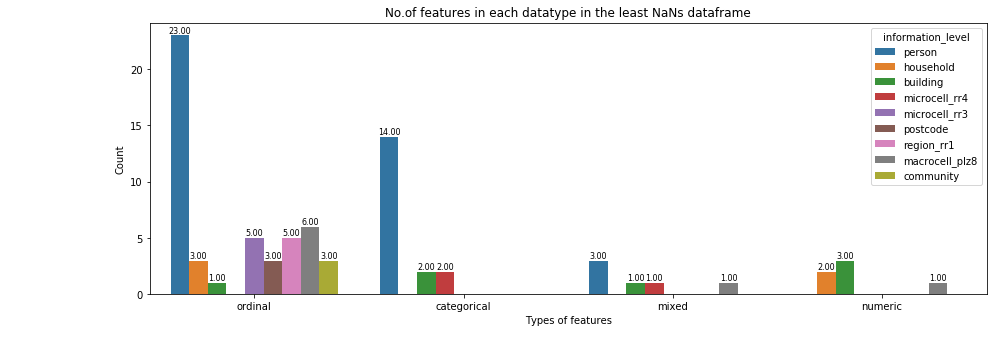

In [37]:
dims_r = (15,5)
fig_r, ax_r = plt.subplots(figsize = dims_r)
types_plt = sns.countplot(x='type', hue= 'information_level', data = feat_info_least_nan)#, ax = ax_r)
plt.legend(loc='upper right', title='information_level')
for bar in types_plt.patches:
    types_plt.annotate(format(bar.get_height(),'.2f'), (bar.get_x() + bar.get_width()/2,bar.get_height()),
                       ha='center', va='center', size=8,xytext=(0,5),textcoords='offset points')

plt.xlabel("Types of features",size=10)
plt.ylabel("Count",size=10)
plt.title("No.of features in each datatype in the least NaNs dataframe")

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

#### *Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?*
- Check all the features belonging to the "categorical" type
- Split into: 
  - **binary categoricals** - having only 2 labels or unique values per feature (either of numeric or non-numeric datatype)
  - **multi-level categoricals** - having >2 labels or unique values per feature (either of numeric or non-numeric datatype)

In [38]:
cat_levels_df = least_nan_df[categorical_least_nan_df].nunique().sort_values()
cat_levels_df

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
FINANZTYP            6
ZABEOTYP             6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

In [39]:
binary_cat = cat_levels_df[cat_levels_df==2]
multilevel_cat = cat_levels_df[cat_levels_df>2]
print("No.of binary categorical variables are:",len(binary_cat.index.tolist()))
print("No.of multi-level categorical variables are:",len(multilevel_cat.index.tolist()))

No.of binary categorical variables are: 5
No.of multi-level categorical variables are: 13


#### *Check for non-numeric (i.e 'object' datatype) categorical features & their unique elements*

In [40]:
cat_object = least_nan_df.loc[:,categorical_least_nan_df].select_dtypes('object').columns
for col in cat_object.tolist():
    print(f'Unique elems in col {col} are: {set(least_nan_df[col].dropna().unique())}')

Unique elems in col OST_WEST_KZ are: {'O', 'W'}
Unique elems in col CAMEO_DEUG_2015 are: {'1', '2', '9', '8', '6', '5', '4', '7', '3'}
Unique elems in col CAMEO_DEU_2015 are: {'5E', '9A', '3C', '8C', '8A', '1C', '8B', '2C', '5B', '5C', '3D', '8D', '9E', '6A', '5F', '6C', '2B', '4C', '9D', '7B', '5A', '3A', '9B', '7A', '2D', '1B', '6F', '6B', '7C', '5D', '7D', '6D', '4A', '2A', '1D', '4D', '6E', '7E', '4B', '9C', '3B', '1A', '1E', '4E'}


#### Re-encode categorical variable(s) to be kept in the analysis.
- ***Part-1:*** Re-encode binary non_numeric variables to dummy variables

In [41]:
re_encode_df = least_nan_df.copy()
re_encode_df['OST_WEST_KZ'] = re_encode_df.OST_WEST_KZ.map({'O':0, 'W':1})

re_encode_df[cat_object].head()

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,1,8,8A
2,1,4,4C
3,1,2,2A
4,1,6,6B
5,1,8,8C


- ***Part-2:*** Re-encode multilevel non_numeric to multiple dummy variables via one-hot encoding
  - One-hot encoding the non-numeric multi-level variable leads to increase in total no.of features

In [42]:
pd.get_dummies(least_nan_df['CAMEO_DEUG_2015']).head()

,1,2,3,4,5,6,7,8,9
1,0,0,0,0,0,0,0,1,0
2,0,0,0,1,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,1,0


In [43]:
pd.get_dummies(least_nan_df['CAMEO_DEU_2015']).head()

,1A,1B,1C,1D,1E,2A,2B,2C,2D,3A,...,7E,8A,8B,8C,8D,9A,9B,9C,9D,9E
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [44]:
print("Categorical features to drop:", multilevel_cat.index.tolist())
re_encode_df = re_encode_df.drop(columns=multilevel_cat.index.tolist())

Categorical features to drop: ['NATIONALITAET_KZ', 'SHOPPER_TYP', 'LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'FINANZTYP', 'ZABEOTYP', 'CJT_GESAMTTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'LP_STATUS_FEIN', 'LP_FAMILIE_FEIN', 'GFK_URLAUBERTYP', 'CAMEO_DEU_2015']


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- There is one binary non-numeric categorical feature i.e **'OST_WEST_KZ'** (O: East, W:West)
  - As this contains only 2 unique 'object' values, they can easily replaced by binary numeric values, i.e {0: East, 1:West}
  - Total no.of unique values per feature still remains same & there is no increase in no.of features.
- There are 2 multi-level non-numeric categorical features i.e **'CAMEO_DEUG_2015'** & **'CAMEO_DEU_2015'**. 
  - Both give information about wealth / life stage topology, former giving a rough scale while the latter giving a detailed scale.
  - **'CAMEO_DEUG_2015'** contains 9 unique values, whereas **'CAMEO_DEU_2015'** contains 44 unique values. One-hot encoding them will significantly increase the total no.of features by (9+44) = 53 features, thereby expanding the feature dimensions
- As we intend to keep the feature dimension & also the no.of variables per feature to minimal, we see that information provided by multi-level categorical features are/can be covered by other features such as **'CAMEO_INTL_2015'** for **'CAMEO_DEUG_2015'** & **'CAMEO_DEU_2015'** , **'FINANZ_'** for **'FINANZTYP'**. 
- Hence, we drop all the multi-level categorical features. 


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

##### *Assess Mixed-type features for re-encoding*
- Check the no.of unique values per mixed-type features to assess the potential increase in overall features if they are re-encoded.
- Check the datatypes of each mixed0type feature to categorize into numeric & non-numeric mixed features

In [45]:
mixed_levels_df = least_nan_df[mixed_least_nan_df].nunique().sort_values()
mixed_levels_df

PLZ8_BAUMAX               5
WOHNLAGE                  8
LP_LEBENSPHASE_GROB      12
PRAEGENDE_JUGENDJAHRE    15
CAMEO_INTL_2015          21
LP_LEBENSPHASE_FEIN      40
dtype: int64

In [46]:
print(least_nan_df.loc[:,mixed_least_nan_df].dtypes)
print(least_nan_df['CAMEO_INTL_2015'].dropna().unique())
print(least_nan_df['PRAEGENDE_JUGENDJAHRE'].dropna().unique())
print(np.sort(least_nan_df['CAMEO_INTL_2015'].astype(float).unique()).tolist())

LP_LEBENSPHASE_FEIN      float64
LP_LEBENSPHASE_GROB      float64
PRAEGENDE_JUGENDJAHRE    float64
WOHNLAGE                 float64
CAMEO_INTL_2015           object
PLZ8_BAUMAX              float64
dtype: object
['51' '24' '12' '43' '54' '22' '14' '13' '15' '41' '34' '55' '33' '25' '23'
 '31' '52' '35' '45' '44' '32']
[ 14.  15.   8.   3.  10.  11.   9.   6.   4.   5.   2.   1.  12.  13.   7.]
[12.0, 13.0, 14.0, 15.0, 22.0, 23.0, 24.0, 25.0, 31.0, 32.0, 33.0, 34.0, 35.0, 41.0, 43.0, 44.0, 45.0, 51.0, 52.0, 54.0, 55.0, nan]


#### *Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.*
- Re-encode into 2 dimensions: **"Decade"** with interval-type & **"Movement"** with binary-type

In [47]:
least_nan_df['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    172952
8.0     134165
5.0      81722
10.0     80527
3.0      51784
15.0     39536
11.0     33173
9.0      32493
6.0      25120
12.0     23337
4.0      20068
1.0      19583
2.0       7340
13.0      5300
7.0       3888
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [48]:
# Re-encode to  interval-type DECADE_ENG (multi-level) & binary MOVEMENT_ENG
#for DECADE_ENG:
decade_dict = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
#for MOVEMENT_ENG: Data values indicating "Mainstream":{1,3,5,8,10,12,14} (label 1), "Avantgarde": {2,4,6,7,9,11,13,15} (label 0)
movt_dict = {1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
re_encode_df['MOVEMENT_ENG'] = least_nan_df['PRAEGENDE_JUGENDJAHRE'].map(movt_dict)
re_encode_df['DECADE_ENG'] = least_nan_df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
re_encode_df.loc[:,['MOVEMENT_ENG','DECADE_ENG','PRAEGENDE_JUGENDJAHRE']].head()

,MOVEMENT_ENG,DECADE_ENG,PRAEGENDE_JUGENDJAHRE
1,1.0,6.0,14.0
2,0.0,6.0,15.0
3,1.0,4.0,8.0
4,1.0,4.0,8.0
5,1.0,2.0,3.0


#### *Plot the distribution of actual feature 'PRAEGENDE_JUGENDJAHRE' vs re-encoded features 'MOVEMENT_ENG' & 'DECADE_ENG'*

Text(0.5,1,'Re_encoded DECADE_ENG')

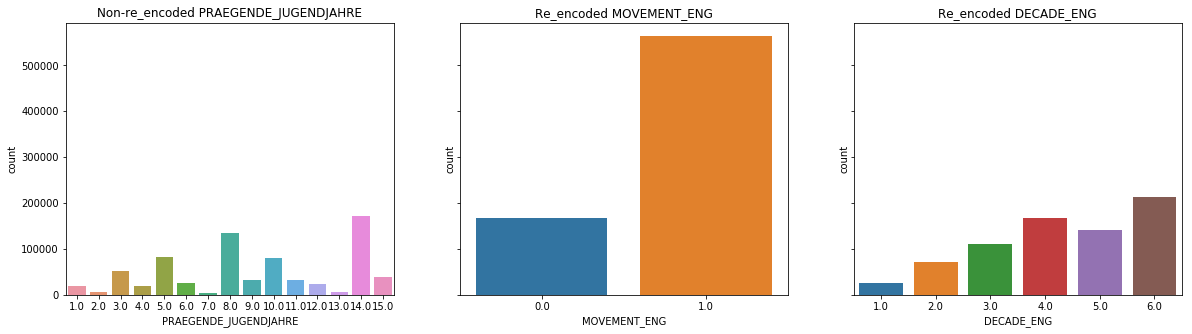

In [49]:
fig, ax_renc = plt.subplots(1,3,figsize = (20,5),sharey=True)
sns.countplot(re_encode_df['PRAEGENDE_JUGENDJAHRE'], ax = ax_renc[0])
ax_renc[0].set_title('Non-re_encoded PRAEGENDE_JUGENDJAHRE')
sns.countplot(re_encode_df['MOVEMENT_ENG'], ax = ax_renc[1])
ax_renc[1].set_title('Re_encoded MOVEMENT_ENG') 
sns.countplot(re_encode_df['DECADE_ENG'], ax = ax_renc[2])
ax_renc[2].set_title('Re_encoded DECADE_ENG')

#### *Investigate "CAMEO_INTL_2015" and engineer two new variables.*

In [50]:
re_encode_df['WEALTH_ENG'] = least_nan_df['CAMEO_INTL_2015'].apply(lambda x: int(eval(x)/10) if x is not np.nan else x)
re_encode_df['LIFE_STAGE_ENG'] = least_nan_df['CAMEO_INTL_2015'].apply(lambda x: int(eval(x)%10) if x is not np.nan else x)

#### *Plot the distribution of actual feature 'CAMEO_INTL_2015' vs re-encoded features 'WEALTH_ENG' & 'LIFE_STAGE_ENG'*

Text(0.5,1,'Re_encoded LIFE_STAGE_ENG')

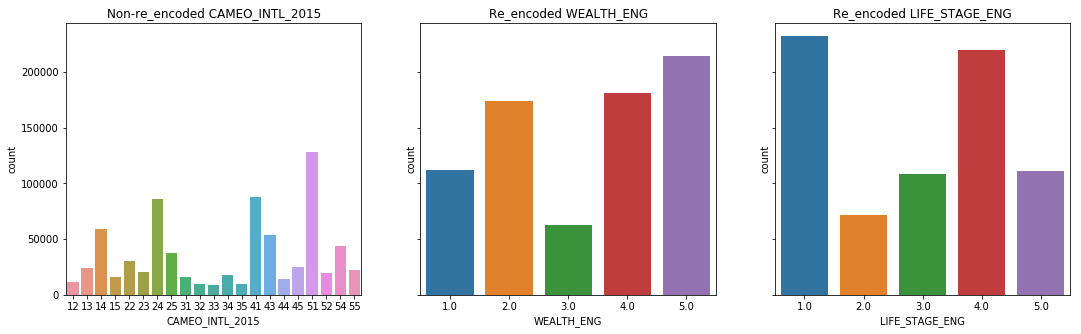

In [51]:
fig, ax_renc = plt.subplots(1,3,figsize = (18,5),sharey=True)
order_orig = [str(int(x)) for x in np.sort(least_nan_df['CAMEO_INTL_2015'].astype(float).dropna().unique()).tolist()]
sns.countplot(re_encode_df['CAMEO_INTL_2015'], ax = ax_renc[0], order = order_orig)
ax_renc[0].set_title('Non-re_encoded CAMEO_INTL_2015')
sns.countplot(re_encode_df['WEALTH_ENG'], ax = ax_renc[1])
ax_renc[1].set_title('Re_encoded WEALTH_ENG') 
sns.countplot(re_encode_df['LIFE_STAGE_ENG'], ax = ax_renc[2])
ax_renc[2].set_title('Re_encoded LIFE_STAGE_ENG') 


#### *Ensuring that null values before & after re-encoding the features remain the same*

In [52]:
print(f'No.of null values in orginal col CAMEO_INTL_2015, engineered WEALTH_ENG & engineered LIFE_STAGE_ENG respectively are:{re_encode_df.CAMEO_INTL_2015.isnull().sum()},\
{re_encode_df.WEALTH_ENG.isnull().sum()},{re_encode_df.LIFE_STAGE_ENG.isnull().sum()}')
print(f'No.of null values in orginal col PRAEGENDE_JUGENDJAHRE, engineered MOVEMENT_ENG & engineered DECADE_ENG respectively are:{re_encode_df.PRAEGENDE_JUGENDJAHRE.isnull().sum()},\
{re_encode_df.MOVEMENT_ENG.isnull().sum()},{re_encode_df.DECADE_ENG.isnull().sum()}')

No.of null values in orginal col CAMEO_INTL_2015, engineered WEALTH_ENG & engineered LIFE_STAGE_ENG respectively are:3231,3231,3231
No.of null values in orginal col PRAEGENDE_JUGENDJAHRE, engineered MOVEMENT_ENG & engineered DECADE_ENG respectively are:16121,16121,16121


In [53]:
print("Mixed type features to be dropped:", mixed_levels_df.index.tolist())
re_encode_df = re_encode_df.drop(columns=mixed_levels_df.index.tolist())

Mixed type features to be dropped: ['PLZ8_BAUMAX', 'WOHNLAGE', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015', 'LP_LEBENSPHASE_FEIN']


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

**1. Engineered features:**
  - Re-encoding **'PRAEGENDE_JUGENDJAHRE'**
    - For **"DECADE_ENG"** - there are 6 decades labelled as follows:
      - **40s** - 1
      - **50s** - 2
      - **60s** - 3
      - **70s** - 4
      - **80s** - 5
      - **90s** - 6
    - For **"MOVEMENT_ENG"** - there are 2 types of movement labelled as follows:
      - **Mainstream** with values {1,3,5,8,10,12,14} - 1
      - **Avantgarde** with values {2,4,6,7,9,11,13,15} - 0
  - Re-encoding **'CAMEO_INTL_2015'**
    - For **"WEALTH_ENG"** - labelled by the ten's place digit *{1: Wealthy household, 5: Poorer household}* 
    - For **"LIFE_STAGE_ENG"** - labelled by the unit's place digit *{1: Pre-family couples & singles, 5: Elders in retirement}*
  
**2. Features to be dropped:**
  - **'PRAEGENDE_JUGENDJAHRE'** & **'CAMEO_INTL_2015'** will be dropped as they are replaced by their respective engineered features. 
  - All other mixed-type features can be dropped since these are covered by other features belonging to the respective information levels, so that we limit the feature dimensions & also the no.of variables to minimum. 


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [54]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
print("Final shape of the dataframe after re-encoding & cleaning", re_encode_df.shape)

Final shape of the dataframe after re-encoding & cleaning (747109, 64)


#### *Ensuring that all rows are of numeric datatype*

In [55]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
if(len(re_encode_df.select_dtypes(include = ['number']).index.tolist())==re_encode_df.shape[0]):
    print("All rows are of numeric datatype in the final dataframe")

All rows are of numeric datatype in the final dataframe


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

#### Create a cleaning function with multiple sub-functions to perform the following:
- **Encoding missing values** - to ensure all missing values are covered in the dataset including the ones mentioned in the "missing_or_unknown" column in the feature info summary, so that we can retrieve the actual no.of NaN values.
- **Removing columns having high NaN values** - Here, we hardcode the columns (with high NaN), which we analyzed from the training dataset i.e the general demographics dataset to drop them from further analysis, so that we have the same columns between the training & testing datasets to avoid dataframe shape mismatch & easier analysis. 
- **Removing rows having high NaN values/row** - Here, we drop & return all rows having >=10% NaN values/row & also return the susbset of rows with >10% NaN values/row as a separate high NaN dataframe.
- **Re-encoding categorical features** - We re-encode 'OST_WEST_KZ' feature while dropping all other categorical features to keep the overall no.of features & the variables/feature to minimal.
- **Re-encoding mixed-type features**- We engineer 'PRAEGENDE_JUGENDJAHRE' & 'CAMEO_INTL_2015' into respective new features. All mixed-type features are dropped after engineering to keep the overall no.of features & the variables/feature to minimal.
- The cleaning function returns the final cleaned dataset which will be used for further analysis & also the subset of dataset with >10% NaN values/row, which wont be used for further analysis but will be still referred for comparison with the final cleaned dataset in certain cases. 

In [56]:
def encode_missing_values(df):
    for col in missing_data_encode.keys():
        df.loc[df[col].isin(missing_data_encode[col]), col] = np.nan
    return df

def remove_high_nan_cols(df):
    df = df.drop(columns=cols_to_drop)
    return df

def remove_high_nan_rows(df):
    perc_nan_row = round(df.isnull().mean(axis=1)*100,2)
    df_highna = df.loc[perc_nan_row > 10.0]
    df = df.loc[perc_nan_row <= 10.0]
    return df, df_highna

def re_encoding_categorical_cols(df):
    df['OST_WEST_KZ'] = df.OST_WEST_KZ.map({'O':0, 'W':1})
    cat_feats = feat_info[feat_info['type'] == 'categorical'] #all categorical feats
    cat_feats = cat_feats[cat_feats['attribute'].isin(df.columns)]  #filter only those categorical feats present in new df
    multilvl_cats = df[cat_feats.attribute.tolist()].nunique()#get the list of binary/multilevel cols
    cat_cols_to_drop = multilvl_cats[multilvl_cats>2].index.tolist() #drop all multi-level categorical cols
    df = df.drop(columns = cat_cols_to_drop)
    return df

def re_encoding_mixed_cols(df):
    decade_dict = {1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    movt_dict = {1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
    df['MOVEMENT_ENG'] = df['PRAEGENDE_JUGENDJAHRE'].map(movt_dict)
    df['DECADE_ENG'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    df['WEALTH_ENG'] = df['CAMEO_INTL_2015'].apply(lambda x: int(eval(x)/10) if x is not np.nan else x)
    df['LIFE_STAGE_ENG'] = df['CAMEO_INTL_2015'].apply(lambda x: int(eval(x)%10) if x is not np.nan else x)
    
    mixed_feats = feat_info[feat_info['type'] == 'mixed'] #all mixed feats
    mixed_feats = mixed_feats[mixed_feats['attribute'].isin(df.columns)]  #filter only those mixed feats present in new df
    df = df.drop(columns = mixed_feats.attribute.tolist())#drop all mixed feats
    return df

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    print("Total no.of missing NaN values originally is:", df.isnull().sum().sum())
    print("Encoding missing values....")
    df = encode_missing_values(df)
    print("Total no.of missing NaN values after encoding is:", df.isnull().sum().sum())
    print("Encoding passed!")
    
    # remove selected columns and rows, ...
    print("Total no.of samples & features respectively are:", df.shape[0],df.shape[1])
    print("Removal of high nan features (>30% NaNs)....")
    df = remove_high_nan_cols(df)
    print("Total no.of features are:", df.shape[1])
    print("Removal of high nan samples (>10% NaNs)....")
    df, df_highna = remove_high_nan_rows(df)
    print("Total no.of rows in final subset of data are:", df.shape[0])
    print("Shape of the subset with high NaN is:", df_highna.shape)
    print("Removal of high NaN cols & rows passed!")
    
    # select, re-encode, and engineer column values.
    print("Re-encoding categorical features....")
    df = re_encoding_categorical_cols(df)
    print("Total no.of features are:", df.shape[1])
    print("Re-encoding mixed features....")
    df = re_encoding_mixed_cols(df)
    print("Total no.of features are:", df.shape[1])
    print("Re-encoding of features passed!")
    
    # Return the cleaned dataframe.
    return df, df_highna


In [57]:
azdias_test = azdias.copy()
cleaned_azdias, cleaned_azdias_highna = clean_data(azdias_test)
print("All tests in the cleaning function passed?", cleaned_azdias.equals(re_encode_df))
print("Shape of cleaned dataframe is:", cleaned_azdias.shape)
print("Shape of cleaned high nan dataframe is:", cleaned_azdias_highna.shape)
cleaned_azdias.head()

Total no.of missing NaN values originally is: 4896838
Encoding missing values....
Total no.of missing NaN values after encoding is: 8373929
Encoding passed!
Total no.of samples & features respectively are: 891221 85
Removal of high nan features (>30% NaNs)....
Total no.of features are: 79
Removal of high nan samples (>10% NaNs)....
Total no.of rows in final subset of data are: 747109
Shape of the subset with high NaN is: (144112, 79)
Removal of high NaN cols & rows passed!
Re-encoding categorical features....
Total no.of features are: 66
Re-encoding mixed features....
Total no.of features are: 64
Re-encoding of features passed!
All tests in the cleaning function passed? True
Shape of cleaned dataframe is: (747109, 64)
Shape of cleaned high nan dataframe is: (144112, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT_ENG,DECADE_ENG,WEALTH_ENG,LIFE_STAGE_ENG
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,6.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,0.0,6.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,1.0,4.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,1.0,4.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1.0,2.0,5.0,4.0


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [58]:
print("No.of missing values in cleaned azdias dataframe:", cleaned_azdias.isnull().sum().sum())
null_cols = cleaned_azdias.isnull().sum() #get all those cols with null values
print(cleaned_azdias.shape)

No.of missing values in cleaned azdias dataframe: 320763
(747109, 64)


In [59]:
#get the dataframe consisting of only columns with null values. There are 33 columns containing atleast 1 null value
null_cols_before_imp = null_cols[null_cols > 0].index.tolist()
print("Null cols are:", null_cols_before_imp)
print("Total no.of null cols are:", len(null_cols_before_imp))
cleaned_azdias[null_cols_before_imp].head()

Null cols are: ['ALTERSKATEGORIE_GROB', 'HEALTH_TYP', 'VERS_TYP', 'W_KEIT_KIND_HH', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ', 'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'MOVEMENT_ENG', 'DECADE_ENG', 'WEALTH_ENG', 'LIFE_STAGE_ENG']
Total no.of null cols are: 33


,ALTERSKATEGORIE_GROB,HEALTH_TYP,VERS_TYP,W_KEIT_KIND_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT_ENG,DECADE_ENG,WEALTH_ENG,LIFE_STAGE_ENG
1,1.0,3.0,2.0,3.0,11.0,0.0,1.0,0.0,0.0,0.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,6.0,5.0,1.0
2,3.0,3.0,1.0,3.0,10.0,0.0,5.0,1.0,3.0,1.0,...,0.0,4.0,4.0,3.0,5.0,2.0,0.0,6.0,2.0,4.0
3,4.0,2.0,1.0,NaN,1.0,0.0,4.0,4.0,1.0,0.0,...,0.0,3.0,4.0,2.0,3.0,3.0,1.0,4.0,1.0,2.0
4,3.0,3.0,2.0,2.0,3.0,0.0,4.0,1.0,4.0,1.0,...,1.0,3.0,3.0,4.0,6.0,5.0,1.0,4.0,4.0,3.0
5,1.0,3.0,2.0,6.0,5.0,0.0,5.0,2.0,2.0,0.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1.0,2.0,5.0,4.0


#### *Apply 3 different cases for feature scaling & compare the results to choose the best one*
- ***Case-1:*** Impute the cleaned general demographics dataset, then fit & transform using standard scaler.

In [60]:
imputer = Imputer()
#case 1: Apply Imputer first 
cleaned_azdias_impute = pd.DataFrame(imputer.fit_transform(cleaned_azdias), index=cleaned_azdias.index, columns=cleaned_azdias.columns)
print("Missing values in imputed dataset:",cleaned_azdias_impute.isnull().sum().sum())
cleaned_azdias_impute[null_cols_before_imp].head()

Missing values in imputed dataset: 0


,ALTERSKATEGORIE_GROB,HEALTH_TYP,VERS_TYP,W_KEIT_KIND_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT_ENG,DECADE_ENG,WEALTH_ENG,LIFE_STAGE_ENG
1,1.0,3.0,2.0,3.000000,11.0,0.0,1.0,0.0,0.0,0.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,6.0,5.0,1.0
2,3.0,3.0,1.0,3.000000,10.0,0.0,5.0,1.0,3.0,1.0,...,0.0,4.0,4.0,3.0,5.0,2.0,0.0,6.0,2.0,4.0
3,4.0,2.0,1.0,4.193366,1.0,0.0,4.0,4.0,1.0,0.0,...,0.0,3.0,4.0,2.0,3.0,3.0,1.0,4.0,1.0,2.0
4,3.0,3.0,2.0,2.000000,3.0,0.0,4.0,1.0,4.0,1.0,...,1.0,3.0,3.0,4.0,6.0,5.0,1.0,4.0,4.0,3.0
5,1.0,3.0,2.0,6.000000,5.0,0.0,5.0,2.0,2.0,0.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1.0,2.0,5.0,4.0


In [61]:
cleaned_azdias_impute.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT_ENG,DECADE_ENG,WEALTH_ENG,LIFE_STAGE_ENG
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,6.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,0.0,6.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,1.0,4.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,1.0,4.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1.0,2.0,5.0,4.0


In [62]:
std_scaler_imputed = StandardScaler()
scaled_azdias_imputed = pd.DataFrame(std_scaler_imputed.fit_transform(cleaned_azdias_impute), index=cleaned_azdias_impute.index,
                                     columns=cleaned_azdias_impute.columns)
scaled_azdias_imputed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT_ENG,DECADE_ENG,WEALTH_ENG,LIFE_STAGE_ENG
1,-1.754375,0.962859,-1.503661,1.559941,-1.049535,1.490708,1.013168,1.331159,-0.536372,1.065804,...,0.407676,1.431055,0.565037,-0.181045,-0.137467,0.676331,0.549948,1.164694,1.173102,-1.259383
2,0.198908,0.962859,-1.503661,0.884836,-1.773085,-0.555630,0.291141,1.331159,1.864378,1.065804,...,-0.968313,0.399695,0.565037,-0.181045,-0.137467,-0.800470,-1.858454,1.164694,-0.877743,0.756001
3,1.175549,0.962859,0.685685,-0.465374,1.121117,-0.555630,-1.152912,-0.831846,-0.536372,-0.280182,...,-0.968313,-0.631666,0.565037,-1.188074,-1.009078,-0.062070,0.549948,-0.219810,-1.561358,-0.587588
4,0.198908,-1.038573,0.685685,0.209731,0.397566,-1.237743,0.291141,-0.831846,-0.536372,1.065804,...,0.407676,-0.631666,-0.336445,0.825984,0.298338,1.414731,0.549948,-0.219810,0.489487,0.084207
5,-1.754375,0.962859,-0.044097,-1.140479,1.121117,-0.555630,-0.430886,1.331159,-0.536372,1.065804,...,0.407676,1.431055,1.466520,-1.188074,-1.009078,-0.062070,0.549948,-1.604315,1.173102,0.756001


- ***Case-2:*** Drop all the rows from the cleaned dataset that are having atleast one null value. Apply standard scaling to the subset having zero null values.

In [63]:
print("Dataset size before dropping missing values:", cleaned_azdias.shape)
print("Dataset size after dropping missing values:", cleaned_azdias.dropna().shape)
print("%rows with atleast one null value:", round((cleaned_azdias.shape[0] - cleaned_azdias.dropna().shape[0])/
                                                  cleaned_azdias.shape[0]*100,2))
#case 2: drop NaN rows entirely & scale it 
azdias_dropna = cleaned_azdias.dropna()
std_scaler_dropna = StandardScaler()
scaled_azdias_dropna = pd.DataFrame(std_scaler_dropna.fit_transform(azdias_dropna), index=azdias_dropna.index,
                                     columns=azdias_dropna.columns)
scaled_azdias_dropna.head()

Dataset size before dropping missing values: (747109, 64)
Dataset size after dropping missing values: (623211, 64)
%rows with atleast one null value: 16.58


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT_ENG,DECADE_ENG,WEALTH_ENG,LIFE_STAGE_ENG
1,-1.746287,0.977825,-1.512226,1.581061,-1.045045,1.539061,1.047076,1.340485,-0.553672,1.044646,...,0.384671,1.441603,0.583438,-0.201175,-0.171843,0.656464,0.553672,1.164455,1.147884,-1.251111
2,0.202108,0.977825,-1.512226,0.900446,-1.765054,-0.531624,0.318375,1.340485,1.806125,1.044646,...,-0.981973,0.400951,0.583438,-0.201175,-0.171843,-0.823841,-1.806125,1.164455,-0.909992,0.749820
4,0.202108,-1.022678,0.692400,0.219832,0.394972,-1.221852,0.318375,-0.856544,-0.553672,1.044646,...,0.384671,-0.639701,-0.314765,0.809745,0.263750,1.396616,0.553672,-0.213395,0.461926,0.082843
5,-1.746287,0.977825,-0.042475,-1.141397,1.114980,-0.531624,-0.410325,1.340485,-0.553672,1.044646,...,0.384671,1.441603,1.481641,-1.212095,-1.043031,-0.083688,0.553672,-1.591245,1.147884,0.749820
6,-0.772089,0.977825,-1.512226,1.581061,-1.765054,1.539061,1.047076,-0.124201,-0.553672,-0.273495,...,-0.981973,1.441603,1.481641,0.809745,0.263750,-0.083688,0.553672,0.475530,-0.909992,-0.584134


- ***Case-3:*** Removing missing values temporarily to compute the scaling parameters before re-introducing those missing values and applying imputation & finally scaling it
  - Fit the subset of cleaned general demographics dataset that are having zero null values with standard scaling, but do not transform it yet, so as to get the scaling parameters
  - Impute the entire cleaned dataset. 
  - Apply transformation using the fitted scaled object on the imputed dataframe

In [64]:
#Case 3:
#1)scale & fit only on subset with no missing values , (=> scaled_azdias_dropna)
#2)Impute the (whole) original dataframe (=> cleaned_azdias_impute)
#3)Transform the imputed dataframe using the fitted scale from #1
std_scaler_dropna_fin = StandardScaler()
std_scaler_dropna_fin.fit(azdias_dropna)
dropna_imputed_scale = pd.DataFrame(std_scaler_dropna_fin.transform(cleaned_azdias_impute),\
                                    index = cleaned_azdias_impute.index,\
                                    columns = cleaned_azdias_impute.columns)
dropna_imputed_scale.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT_ENG,DECADE_ENG,WEALTH_ENG,LIFE_STAGE_ENG
1,-1.746287,0.977825,-1.512226,1.581061,-1.045045,1.539061,1.047076,1.340485,-0.553672,1.044646,...,0.384671,1.441603,0.583438,-0.201175,-0.171843,0.656464,0.553672,1.164455,1.147884,-1.251111
2,0.202108,0.977825,-1.512226,0.900446,-1.765054,-0.531624,0.318375,1.340485,1.806125,1.044646,...,-0.981973,0.400951,0.583438,-0.201175,-0.171843,-0.823841,-1.806125,1.164455,-0.909992,0.749820
3,1.176305,0.977825,0.692400,-0.460783,1.114980,-0.531624,-1.139026,-0.856544,-0.553672,-0.273495,...,-0.981973,-0.639701,0.583438,-1.212095,-1.043031,-0.083688,0.553672,-0.213395,-1.595951,-0.584134
4,0.202108,-1.022678,0.692400,0.219832,0.394972,-1.221852,0.318375,-0.856544,-0.553672,1.044646,...,0.384671,-0.639701,-0.314765,0.809745,0.263750,1.396616,0.553672,-0.213395,0.461926,0.082843
5,-1.746287,0.977825,-0.042475,-1.141397,1.114980,-0.531624,-0.410325,1.340485,-0.553672,1.044646,...,0.384671,1.441603,1.481641,-1.212095,-1.043031,-0.083688,0.553672,-1.591245,1.147884,0.749820
6,-0.772089,0.977825,-1.512226,1.581061,-1.765054,1.539061,1.047076,-0.124201,-0.553672,-0.273495,...,-0.981973,1.441603,1.481641,0.809745,0.263750,-0.083688,0.553672,0.475530,-0.909992,-0.584134
7,-1.746287,-1.022678,-0.042475,0.219832,0.394972,-1.221852,0.318375,-0.856544,-0.553672,-1.591635,...,-0.981973,0.400951,0.583438,-1.212095,-0.171843,-0.823841,0.553672,-0.213395,-1.595951,0.749820
8,0.202108,-1.022678,0.692400,0.900446,-1.045045,0.848833,-0.410325,-0.856544,1.806125,1.044646,...,0.384671,-0.639701,-0.314765,-1.212095,-0.607437,-0.083688,-1.806125,0.475530,-1.595951,0.082843
9,0.202108,0.977825,-0.777350,0.900446,-1.045045,0.158605,1.775776,0.608142,1.806125,-0.273495,...,0.384671,-0.639701,-0.314765,-1.212095,-1.043031,-1.563993,-1.806125,1.164455,-1.595951,1.416797
10,0.202108,0.977825,-0.777350,-0.460783,1.114980,0.158605,-1.139026,1.340485,-0.553672,-0.273495,...,-0.981973,-0.639701,-0.314765,0.809745,0.263750,1.396616,0.553672,-1.591245,1.147884,-1.251111


In [65]:
print(f'Mean of all 3 cases:\n1.Mean of scaling after imputing:{round(scaled_azdias_imputed.mean().sum(),4)}\
\n2.Mean of scaling after removing all rows with missing values:{round(scaled_azdias_dropna.mean().sum(),4)}\
\n3.Mean of dataset after missing values are removed temporarily, fitting scaling with non-missing values, re-introducing missing\
values & then applying imputation, then transforming with fitted scale:{round(dropna_imputed_scale.mean().sum(),4)}')

Mean of all 3 cases:
1.Mean of scaling after imputing:0.0
2.Mean of scaling after removing all rows with missing values:-0.0
3.Mean of dataset after missing values are removed temporarily, fitting scaling with non-missing values, re-introducing missingvalues & then applying imputation, then transforming with fitted scale:0.1281


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

3 different cases of feature scaling were performed with observations reported as below:

- **Case-1:** Impute the cleaned general demographics dataset, then fit & transform using standard scaler.
  - Mean of the final scaled dataset is very small , i.e close to 0. This leads to possibility of reducing the variability.
- **Case-2:** Drop all the rows from the cleaned dataset that are having atleast one null value. Apply standard scaling to the subset having zero null values.
  - There are 16.58% rows with null values which are dropped. Dropping samples will lead to potential loss of information which is not desired.
- **Case-3:** Removing missing values temporarily to compute the scaling parameters before re-introducing those missing values and applying imputation & finally scaling it
  - The scaling parameters are computed on the subset having no null values but the scaling transformation is applied on the whole imputed dataset ensuring there is no loss of information. Also the mean of scaled dataset in this case is 0.13 that shows possibility of higher variability. 

Therefore, from all the observations above, ***Case-3*** method of scaling is chosen as the final feature scaling method


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

####  *Apply PCA to the data.*
- No PCA components are set now, which means total PCA components will be same as the total no.of features of the dataset. 
- This is done to assess the general trend in variability over all PCA components

In [66]:
all_compts_pca = PCA()
X_allcompts_pca = pd.DataFrame(all_compts_pca.fit_transform(dropna_imputed_scale), index = dropna_imputed_scale.index,
                               columns = dropna_imputed_scale.columns)

print("Variability Ratio over all PCA components:", all_compts_pca.explained_variance_ratio_, sep='\n')
X_allcompts_pca.head() #Check the PCA transformed dataset (total PCA components = total no.of features of the dataset)

Variability Ratio over all PCA components:
[  1.69022778e-01   1.33875037e-01   9.25539334e-02   5.20624274e-02
   3.84013517e-02   3.19027633e-02   2.97150628e-02   2.72840720e-02
   2.38060992e-02   2.27701329e-02   2.07835664e-02   1.99483033e-02
   1.92509335e-02   1.74091244e-02   1.62663369e-02   1.56686121e-02
   1.52602203e-02   1.43331664e-02   1.37381874e-02   1.28296247e-02
   1.26190459e-02   1.18631197e-02   1.15237391e-02   1.06740051e-02
   1.05059279e-02   8.93446368e-03   7.75782335e-03   7.52819317e-03
   7.41034762e-03   7.20268037e-03   6.69810856e-03   6.62163718e-03
   6.57596473e-03   6.20794160e-03   6.00931615e-03   5.91753622e-03
   5.39843557e-03   4.84978937e-03   4.74627263e-03   4.36167949e-03
   4.16196141e-03   3.94583904e-03   3.91246881e-03   3.75186227e-03
   3.67202546e-03   3.32880916e-03   3.21516888e-03   3.11599828e-03
   2.91234144e-03   2.79777677e-03   2.65201609e-03   2.60066286e-03
   2.49935657e-03   2.33206412e-03   2.22159209e-03   2.1429

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT_ENG,DECADE_ENG,WEALTH_ENG,LIFE_STAGE_ENG
1,3.907813,-2.656814,-2.895801,-0.431157,-2.502552,2.187075,0.663763,0.904260,1.286294,-0.612649,...,0.120822,0.177483,-0.022836,-0.390735,-0.231542,-0.427436,-0.082398,0.153045,-0.109192,-0.003337
2,-0.893351,0.179040,-3.051474,2.232259,-0.914724,-0.245780,0.300869,-0.987308,0.879587,-1.281140,...,-0.939094,0.178652,-0.427022,-0.037146,0.590146,-0.643693,0.045186,-0.003254,0.080130,0.001643
3,-4.068326,1.143319,-0.822069,-0.918252,0.781452,0.890183,-1.684066,-0.518176,-1.375987,-0.238331,...,-0.334542,-0.538654,0.416983,0.118795,0.104403,0.493888,-0.215324,0.100204,-0.650749,-0.009887
4,0.571167,0.223031,3.234554,0.628171,1.396149,-2.795867,-0.616678,2.317452,1.316415,-0.630746,...,-0.097399,0.207310,0.273939,0.240731,-0.161093,0.134900,-0.438058,0.386383,-0.398303,0.005010
5,-0.710984,-1.353125,-1.047911,-1.814119,-3.407398,-1.052798,0.452400,-0.619059,-2.744463,1.536279,...,-0.463792,0.268748,0.317014,0.021618,0.052242,0.050954,0.213798,-0.033906,-0.346904,-0.006791


#### *Scree plot function to investigate the variance accounted for by each principal component & also the cummulative variance ratio* 

In [67]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca, var_only, cum_var, annotate):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 7))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    if(var_only): ax.bar(ind, vals)
    if(cum_var): ax.plot(ind, cumvals, marker='o')
    if(annotate):
        for i in range(num_components):
            ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=9)
 
    ax.xaxis.set_tick_params(width=1)
    ax.set_xticks(ind, minor=False);
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    if(var_only and cum_var):
        ax.set_ylabel("Combined plot: Variance Explained (%)")
        plt.title('Combined plot: Variance Per Principal Component')
    elif(cum_var):
        ax.set_ylabel("Cumulative Variance Explained (%)")
        plt.title('Explained Cumulative Variance Per Principal Component')
    else:
        ax.set_ylabel("Variance Explained (%)")
        plt.title('Explained Variance Per Principal Component')


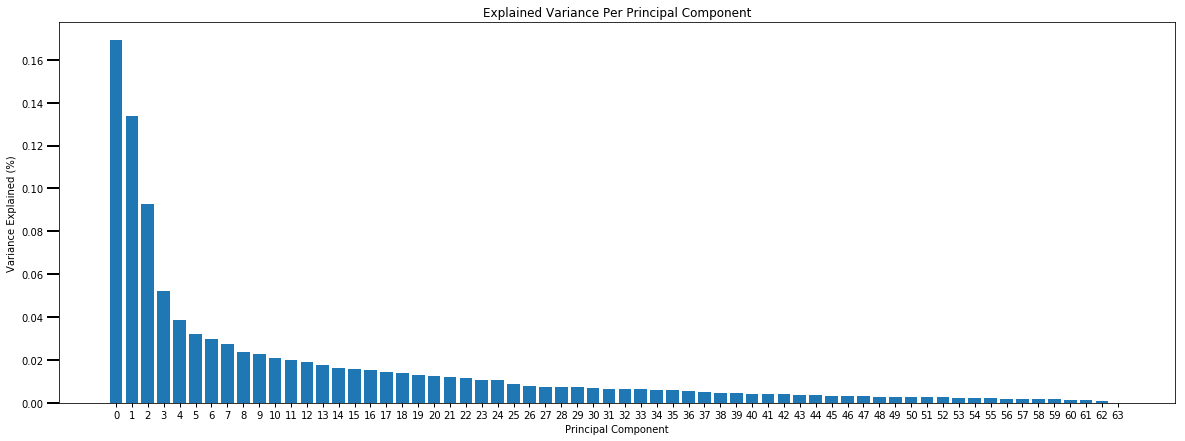

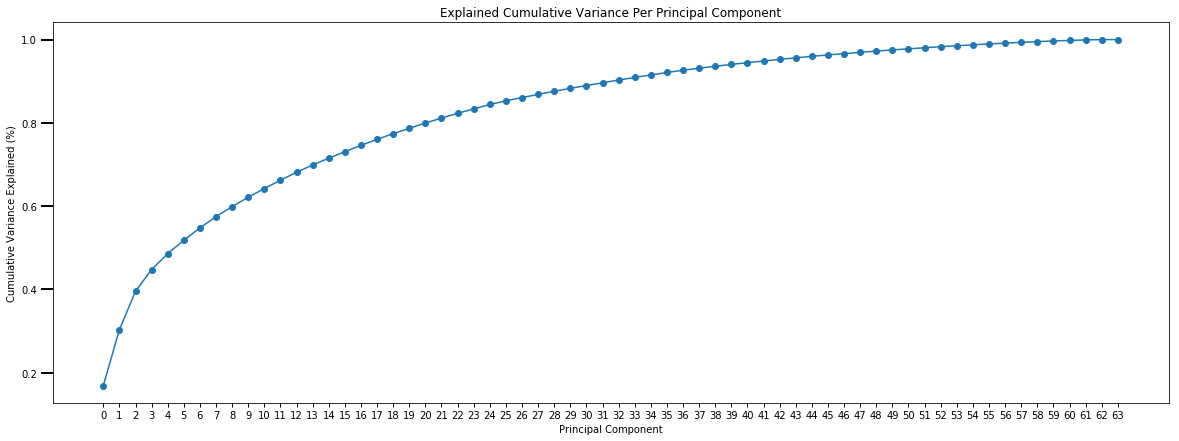

In [68]:
scree_plot(all_compts_pca, var_only = True, cum_var=False, annotate=False) #Explained variance Ratio
scree_plot(all_compts_pca, var_only = False, cum_var=True, annotate=False)  #Cumulative Explained variance ratio

#### *Re-apply PCA to the data while selecting for number of components to retain.*
- ***Part-1:*** Checking the scree-plot by selecting 25 PCA components 

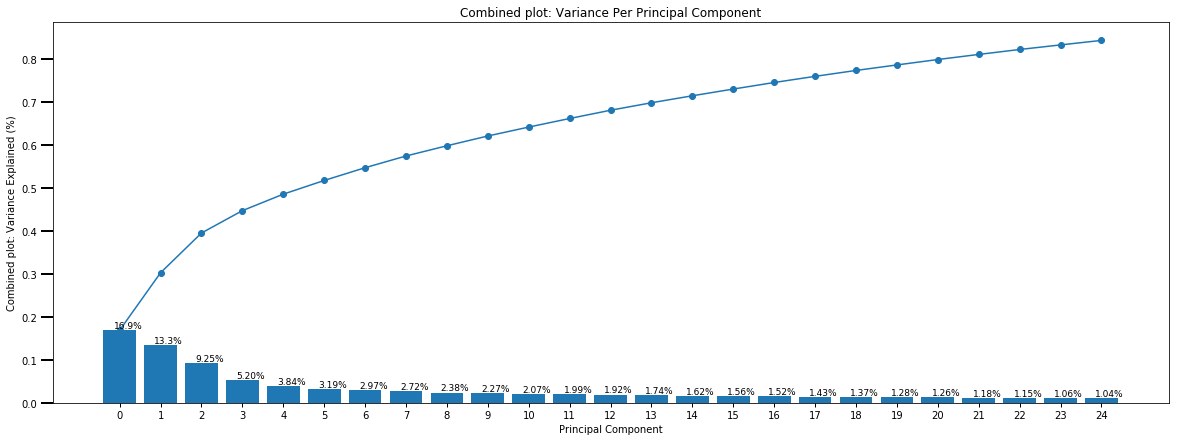

In [69]:
pca25 = PCA(n_components=25)
X_pca25 = pca25.fit_transform(dropna_imputed_scale)
scree_plot(pca25, var_only = True, cum_var = True, annotate = True)


***Part-2:*** Checking the scree-plot by selecting 12 PCA components

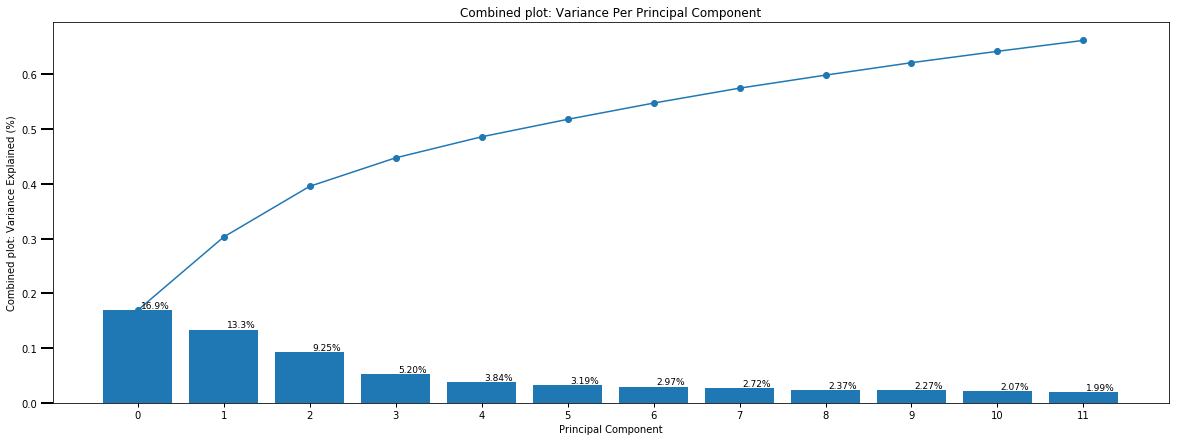

In [70]:
final_pca = PCA(n_components=12)
X_pca = final_pca.fit_transform(dropna_imputed_scale)
X_fin = pd.DataFrame(X_pca) #tranformed dataset based on final pca components (reduced dimensionality)

scree_plot(final_pca, var_only = True, cum_var = True, annotate = True)

In [71]:
print(f'Shape of pca components:{final_pca.components_.shape} & shape of scaled & imputed dataset:{dropna_imputed_scale.shape}')
print("PCA transformed azdias dataset of shape", X_fin.shape)
print("Cumulative explained variance ratio with 12 PCA components is:", np.cumsum(final_pca.explained_variance_ratio_)[-1])
X_fin.head()

Shape of pca components:(12, 64) & shape of scaled & imputed dataset:(747109, 64)
PCA transformed azdias dataset of shape (747109, 12)
Cumulative explained variance ratio with 12 PCA components is: 0.662050155354


,0,1,2,3,4,5,6,7,8,9,10,11
0,3.907820,-2.656849,-2.895699,-0.431957,-2.498046,2.192836,0.646744,0.903149,1.299250,-0.589784,0.132180,1.815901
1,-0.893362,0.178990,-3.051582,2.233810,-0.909599,-0.230102,0.327590,-0.965831,0.958118,-1.287006,-1.013152,-0.246106
2,-4.068315,1.143250,-0.822025,-0.919790,0.792398,0.903066,-1.719201,-0.479213,-1.380021,-0.300602,0.585300,-1.099571
3,0.571164,0.223057,3.234472,0.628699,1.395750,-2.806041,-0.616291,2.315259,1.306794,-0.629946,1.175299,1.286235
4,-0.710983,-1.353199,-1.047872,-1.814357,-3.398031,-1.032748,0.456072,-0.609695,-2.719492,1.566446,0.197099,2.341871


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

**Observations on default PCA object when no number of components were set or the default #PCA components = #total features of dataset**
  - The bar graph decreases sharply until 8th PCA component (starting from PCA=0), then starts stabilizing at some points or increases with small increments. 
  - After 25th PCA component, the variance droops further & significantly keeps on decreasing till the last PCA component.
  - Until 25th component, cumulative variance measures upto 85%(from PCA=0 to PCA=24) of the total information(variance) of the dataset which is sufficient for our analysis, however, 25 components or 25 features are still a lot when it comes to computation time.
  - Using only **12 components**, the varaince stability is attained with a cumulative variance of **66%** (from PCA=0 to PCA=11) which should be sufficient for our analysis that can also help in faster computation & result in the optimal number of reduced dimensions. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

#### *Check the weights associated to each feature given by the respective PCA components*

In [72]:
pca_wt = pd.DataFrame(final_pca.components_, columns=dropna_imputed_scale.columns)
pca_wt

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT_ENG,DECADE_ENG,WEALTH_ENG,LIFE_STAGE_ENG
0,-0.117469,0.005741,-0.219338,0.143639,-0.110545,0.064978,0.073449,0.164506,-0.108324,0.028295,...,0.217775,0.041892,-0.167240,0.144146,0.196961,0.135336,0.106804,0.099743,0.207790,-0.123553
1,0.260408,0.086402,0.071942,-0.241817,0.233672,-0.212121,-0.231203,0.116124,-0.013394,-0.058084,...,0.086120,0.013031,-0.069425,0.065168,0.088207,0.063047,0.011307,-0.251494,0.070896,0.002776
2,0.076469,-0.372709,0.159924,-0.103478,0.097453,-0.190491,-0.095107,-0.049542,0.050147,-0.015068,...,0.043172,0.005202,-0.035790,0.032340,0.046164,0.030478,-0.049251,-0.104857,0.023715,-0.007891
3,-0.043501,0.040289,0.063916,-0.000165,-0.016322,-0.126466,0.090610,-0.109496,0.389440,0.005515,...,0.079484,0.148247,0.042546,0.046290,0.249771,0.093935,-0.387663,0.039851,-0.128139,0.059711
4,0.005333,0.007847,0.086144,-0.006438,-0.064720,0.036064,-0.046019,-0.097921,0.063663,0.012903,...,0.031794,-0.470048,-0.393461,0.217457,0.095031,0.140428,-0.061394,0.028470,-0.011571,0.020858
5,0.008749,0.011521,-0.024370,0.004722,-0.040009,0.023552,-0.025371,0.006053,0.011438,-0.013210,...,0.108458,0.065365,-0.026492,-0.155994,-0.067559,-0.208470,-0.013963,0.019164,-0.065987,0.038187
6,-0.042782,0.018247,-0.024465,-0.001613,0.036690,-0.013339,-0.005592,0.092877,0.013517,-0.027852,...,-0.054965,-0.227775,-0.124913,-0.107133,-0.017203,-0.051049,-0.014658,-0.022848,-0.038226,0.064381
7,0.040634,-0.058642,0.048547,0.063624,-0.015087,0.086296,0.042698,-0.184801,-0.034431,0.193830,...,0.045492,0.182417,0.101801,0.010510,0.104240,0.034456,0.034970,0.101660,0.033435,-0.076227
8,0.144185,-0.007241,-0.115913,0.110550,-0.109537,0.138704,0.059671,0.114892,0.064888,-0.168007,...,0.058789,-0.014342,-0.061006,-0.033418,-0.124539,-0.036466,-0.065259,0.104365,0.072771,-0.009204
9,-0.027342,0.096809,0.061352,-0.132409,0.100342,-0.036747,-0.159615,0.083459,-0.009680,-0.388269,...,0.036809,0.152831,0.083016,0.164601,0.046748,0.073253,0.008051,-0.152622,0.025976,0.050696


#### *Developing common functions to split into top 15 positively weighted & top 15 negatively weighted features per PCA component for interpretation*

In [73]:
def map_weights_to_feats_pca(pca_comp, pca_df):
    pca_comp_wt = pca_df.iloc[pca_comp]
    neg_pca_comp_wt = pca_comp_wt[pca_comp_wt<0].sort_values().to_frame().reset_index().\
                                                  rename(columns={pca_comp:'Weights_neg', 'index':'neg_index'})
    pos_pca_comp_wt = pca_comp_wt[pca_comp_wt>0].sort_values(ascending=False).to_frame().\
                                                  reset_index().rename(columns={pca_comp:'Weights_pos', 'index':'pos_index'})
    #print(f'No.of Negative weight components of PCA component {pca_comp+1}: {neg_pca_comp_wt.shape[0]}')
    #print(f'No.of Positive weight components of PCA component {pca_comp+1}: {pos_pca_comp_wt.shape[0]}')
    return pos_pca_comp_wt, neg_pca_comp_wt

def weight_distribution_bar(neg_wts, pos_wts,pca_comp):
    top15_wt_df = pd.concat([neg_wts.iloc[:15], pos_wts.iloc[:15]], axis=1)
    return top15_wt_df.style.set_caption(f'Top 15 +ve & -ve weights for PCA component {pca_comp+1}').\
                             set_precision(4).bar(color=['#d65f5f', '#5fba7d'],align='mid').highlight_null(null_color='yellow')

#### *Map weights for the first principal component to corresponding feature names and then print the linked values, sorted by weight.*

In [74]:
pos_0, neg_0 = map_weights_to_feats_pca(0, pca_wt)
pca0_wt_dist = weight_distribution_bar(neg_0,pos_0,0)
pca0_wt_dist

,neg_index,Weights_neg,pos_index,Weights_pos
0,MOBI_REGIO,-0.2425,PLZ8_ANTG3,0.2264
1,PLZ8_ANTG1,-0.2245,PLZ8_ANTG4,0.2178
2,KBA05_ANTG1,-0.223,HH_EINKOMMEN_SCORE,0.2082
3,FINANZ_MINIMALIST,-0.2193,WEALTH_ENG,0.2078
4,KBA05_GBZ,-0.2183,ORTSGR_KLS9,0.197
5,KONSUMNAEHE,-0.1694,EWDICHTE,0.1969
6,PLZ8_GBZ,-0.1672,FINANZ_HAUSBAUER,0.1645
7,INNENSTADT,-0.164,PLZ8_ANTG2,0.1539
8,BALLRAUM,-0.126,KBA05_ANTG4,0.153
9,LIFE_STAGE_ENG,-0.1236,ARBEIT,0.1441


**PCA0 or 1st PCA component:**
  - **Positively Weighted features:**
    - PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region (0: no 6-10 family homes, 3: high share of 6-10 family homes)
      - Since most positive, it reflects *high share of 6-10 family homes*
    - PLZ8_ANTG4 - Number of 10+ family houses in the PLZ8 region (1: mainly 1-2 family homes, 5: mainly business buildings)
      - Since most positive, it reflects *mainly business buildings*
    - HH_EINKOMMEN_SCORE - Estimated household net income (1: highest income, 6: very low income)
      - Since most positive, it reflects *very low income*
    - ENG_WEALTH - Household wealth - Engineered (1: Wealthy Households, 5: Poorer Households)
      - Since most positive, it reflects *Poorer Households*
    
  - **Negatively weighted features:**
    - MOBI_REGIO : Movement patterns (1: very high movement, 6: none)
       - Since most negative, it reflects *no movement patterns*
    - PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region (0: no 1-2 family homes, 4: very high share of 1-2 family homes)
       - Since most negative, it reflects *Higher share of of 1-2 family homes*
    - KBA05_ANTG1 : Number of 1-2 family houses in the microcell (0: no 1-2 family homes, 4: very high share of 1-2 family homes)
       - Since most negative, it reflects *Higher share of of 1-2 family homes*
    - FINANZ_MINIMALIST : Financial typology - MINIMALIST: low financial interest (1: very high, 5: very low)
       - Since most negative, it reflects *very low financial interest*


#### *Map weights for the second principal component to corresponding feature names and then print the linked values, sorted by weight.*

In [75]:
pos_1, neg_1 = map_weights_to_feats_pca(1, pca_wt)
pca1_wt_dist = weight_distribution_bar(neg_1,pos_1,1)
pca1_wt_dist

,neg_index,Weights_neg,pos_index,Weights_pos
0,SEMIO_REL,-0.2609,ALTERSKATEGORIE_GROB,0.2604
1,DECADE_ENG,-0.2515,FINANZ_VORSORGER,0.2337
2,FINANZ_SPARER,-0.2418,SEMIO_ERL,0.2297
3,FINANZ_UNAUFFAELLIGER,-0.2312,SEMIO_LUST,0.1812
4,SEMIO_TRADV,-0.2276,RETOURTYP_BK_S,0.1681
5,SEMIO_PFLICHT,-0.2263,FINANZ_HAUSBAUER,0.1161
6,SEMIO_KULT,-0.2168,W_KEIT_KIND_HH,0.116
7,FINANZ_ANLEGER,-0.2121,SEMIO_KRIT,0.1136
8,SEMIO_FAM,-0.179,SEMIO_KAEM,0.1054
9,SEMIO_RAT,-0.1699,PLZ8_ANTG3,0.09081


**PCA1 or 2nd PCA component:**
  - **Positively Weighted features:**
    - ALTERSKATEGORIE_GROB - Estimated age based on given name analysis (1: < 30 years old, 9: uniformly distributed)
      - Since most positive, it reflects *uniformly distributed or much older people*
    - FINANZ_VORSORGER - Financial typology - VORSORGER: be prepared (1: very high, 5: very low)
      - Since most positive, it reflects *least financial preparation*
    - SEMIO_ERL - Personality typology - event-oriented (1: highest affinity, 7: lowest affinity)
      - Since most positive, it reflects *least affinity to event-orientation*
    - SEMIO_LUST - Personality typology - sensual-minded (1: highest affinity, 7: lowest affinity)
      - Since most positive, it reflects *least affinity to sensual-minded*
    
  - **Negatively weighted features:**
    - SEMIO_REL - Personality typology - religious (1: highest affinity, 7: lowest affinity)
       - Since most negative, it reflects *lowest affinity to religion*
    - DECADE_ENG - Dominating decades of person's youth - Engineered (1: 40s or war & reconstruction years, 6: 90s or digital media kids or ecological awareness)
       - Since most negative, it reflects *person belonging to 90s or younger/tech savvy generation*
    - FINANZ_SPARER	 - Financial typology - SPARER: money-saver (1: very high, 5: very low)
       - Since most negative, it reflects *very low on money saving*
    - FINANZ_UNAUFFAELLIGER	 - Financial typology - UNAUFFAELLIGER: inconspicuous (1: very high, 5: very low)
       - Since most negative, it reflects *less inconspicuous people*


#### *Map weights for the third principal component to corresponding feature names and then print the linked values, sorted by weight.*

In [76]:
pos_2, neg_2 = map_weights_to_feats_pca(2, pca_wt)
pca2_wt_dist = weight_distribution_bar(neg_2,pos_2,2)
pca2_wt_dist

,neg_index,Weights_neg,pos_index,Weights_pos
0,ANREDE_KZ,-0.3727,SEMIO_VERT,0.3524
1,SEMIO_KAEM,-0.3332,SEMIO_SOZ,0.2664
2,SEMIO_DOM,-0.3087,SEMIO_FAM,0.2529
3,SEMIO_KRIT,-0.2713,SEMIO_KULT,0.2354
4,SEMIO_RAT,-0.2119,FINANZ_MINIMALIST,0.1599
5,FINANZ_ANLEGER,-0.1905,RETOURTYP_BK_S,0.112
6,SEMIO_ERL,-0.178,FINANZ_VORSORGER,0.09745
7,DECADE_ENG,-0.1049,W_KEIT_KIND_HH,0.08781
8,FINANZ_SPARER,-0.1035,SEMIO_REL,0.07863
9,FINANZ_UNAUFFAELLIGER,-0.09511,ALTERSKATEGORIE_GROB,0.07647


**PCA2 or 3rd PCA component:**
  - **Positively Weighted features:**
    - SEMIO_VERT - Personality typology - dreamful (1: highest affinity, 7: lowest affinity)
      - Since most positive, it reflects *more realistic or less dreamy personality*
    - SEMIO_SOZ - Personality typology - socially minded (1: highest affinity, 7: lowest affinity)
      - Since most positive, it reflects *least socially minded*
    - SEMIO_FAM	- Personality typology - family minded (1: highest affinity, 7: lowest affinity)
      - Since most positive, it reflects *people who are hardly family minded*
    - SEMIO_KULT - Personality typology - cultural-minded (1: highest affinity, 7: lowest affinity)
      - Since most positive, it reflects *least affinity to culture*
    
  - **Negatively weighted features:**
    - ANREDE_KZ	 - Gender (1: male, 2: female)
       - Since most negative, it reflects *female*
    - SEMIO_KAEM - Personality typology - combative attitude (1: highest affinity, 7: lowest affinity)
       - Since most negative, it reflects *lowset affinity to combative attitude*
    - SEMIO_DOM	- Personality typology - dominant minded (1: highest affinity, 7: lowest affinity)
       - Since most negative, it reflects *least dominant people*
    - SEMIO_KRIT - Personality typology - critical minded (1: highest affinity, 7: lowest affinity)
       - Since most negative, it reflects *people hardly with a critical mindset*


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

**Drawing observations on top 4 positively weighted & negatively weighted features for the 1st,2nd & 3rd PCA components as below:**

- **PCA0 or 1st PCA component:**
 - **Positively weighted** features such as: PLZ8_ANTG3, PLZ8_ANTG4, HH_EINKOMMEN_SCORE, WEALTH_ENG give information about people coming from poorer households with low income & densely populated areas.
 - **Negatively weighted** features such as: MOBI_REGIO, PLZ8_ANTG1, KBA05_ANTG1, FINANZ_MINIMALIST give information about people coming from less densely populated areas who are well settled or hardly on the move & have lower financial minimalism
 
- **PCA1 or 2nd PCA component:**
 - **Positively weighted** features such as: ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, SEMIO_ERL, SEMIO_LUST give information about older people having poorly prepared financially & least even oriented or sensual minded.
 - **Negatively weighted** features such as: SEMIO_REL, DECADE_ENG, FINANZ_SPARER, FINANZ_UNAFFAELLIGER give information about younger/tech savvy generation who are hardly religious, but are not good in money savings & least inconspicious
 
- **PCA2 or 3rd PCA component:**
 - **Positively weighted** features such as: SEMIO_VERT, SEMIO_SIZ, SEMIO_FAM, SEMIO_KULT give information about more realistic people who aren't socially/family minded & have least interested in culture.
 - **Negatively weighted** features such as: ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT give information about females who do not have a combative/dominant attitude nor do they have a critical mindset.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

#### *Apply KMeans clustering on the PCA transformed data over a range of clusters & measure the kmeans-scores*

In [77]:
from sklearn.cluster import KMeans

In [78]:
def kmeans_clusters(cluster_list, X):
    score = []
    for c in cluster_list:
# Over a number of different cluster counts...
        kmeans = KMeans(n_clusters=c,random_state=7)
    # run k-means clustering on the data and...
        kmeans.fit(X)    
    # compute the average within-cluster distances.
        score.append(kmeans.score(X))
    return score

num_clusters = range(2,26)
scores_kmeans = kmeans_clusters(num_clusters, X_fin)
print("Actual scores are:", scores_kmeans)

Actual scores are: [-25830868.221807029, -22683811.907587282, -20768538.031496935, -19437080.981520664, -18282650.752282728, -17255280.943799887, -16454675.52467823, -15835681.316591607, -15357484.583105065, -14878328.840093236, -14486448.960106052, -14191387.480978627, -13922718.91619515, -13711539.539068591, -13460732.154655939, -13267753.436351564, -13044836.272671919, -12853349.310596986, -12680302.787695251, -12511175.402404508, -12349153.480986634, -12204183.493569979, -12005038.619728817, -11887277.14064201]


#### *Investigate the change in within-cluster distance (i.e kmeans-score) across number of clusters by plotting a scree plot to find the elbow point* 

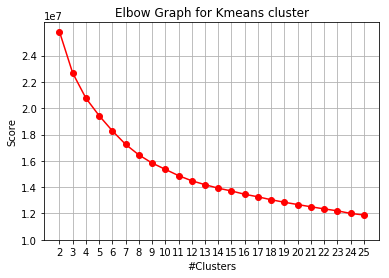

In [79]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(num_clusters, list(map(abs,scores_kmeans)), 'ro-')
plt.xticks(np.arange(2,26))
plt.yticks(np.arange(1,2.5,0.2)*1e7)
plt.xlabel('#Clusters',size=10)
plt.ylabel('Score',size=10)
plt.title('Elbow Graph for Kmeans cluster')
plt.grid()

#### *Get the elbow point to choose the optimal number of clusters, re-fit the k-means model with it and obtain cluster predictions for the general population demographics data.*

In [80]:
k=8
kmeans_fin = KMeans(k,random_state=7)
kmeans_fin.fit(X_pca)

centroids = kmeans_fin.cluster_centers_
label = kmeans_fin.labels_
print("Cluster centers:", centroids) #kx12 pcas is the array size
print("Cluster labels on training:", label) #cluster prediction on training dataset (right now we havent defined testing dataset)



Cluster centers: [[-1.09376118 -4.4482423   1.77855708 -0.09237499 -0.08071169  0.06161275
   0.02910211  0.06695401  0.2215977  -0.19689008 -0.28929734 -0.25674243]
 [ 1.69570664  4.0003803  -1.45105663 -0.19439367 -0.10963449  0.02830979
  -0.13267347  0.03069527  0.23516711 -0.07662316 -0.00849296  0.01750221]
 [-3.40128833 -0.02070802  2.21504766 -0.01292712  0.09609393 -0.01255447
   0.04324288  0.13044426 -0.20562746 -0.06678415  0.06819634  0.14871931]
 [ 4.38546642 -1.20008939 -2.61500177  0.36345845  0.06414746 -0.07512164
   0.10719265 -0.27176498 -0.17076239  0.47555125  0.11791661 -0.05055964]
 [-3.45914418  1.63197439 -1.81798296  0.29129169  0.19356268  0.04636581
   0.04682876  0.08787729  0.06054031 -0.02169907 -0.09676682 -0.0993929 ]
 [ 4.23320965 -2.53428463  2.38949945 -0.07852561  0.03556943  0.03338341
  -0.03214331  0.16224557  0.29405782 -0.28261574 -0.29147259 -0.28492996]
 [-0.91463584 -2.98932182 -3.07875871  0.07303424 -0.12697888  0.07906372
   0.15583126 -

#### *Plot the k-means cluster predictions for the general demographics dataset*

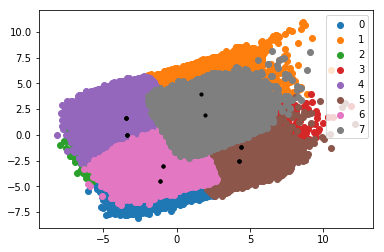

In [81]:
def plot_cluster(data, clust_labels,centroid_clus):
    u_labels = np.unique(clust_labels)
    for i in u_labels:
        plt.scatter(data[clust_labels == i , 0] , data[clust_labels == i , 1] , label = i)
        plt.scatter(centroid_clus[:,0] , centroid_clus[:,1] , s = 10, color = 'k')
    plt.legend()
    plt.show()

plot_cluster(X_pca,label,centroids)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

- Kmeans clustering method was tried on a range of clusters from two until 25. 
- Scree plot was plotted & the elbow point was found when number of clusters = 8, as after that, the kmeans-score doesnt have significant changes
- Re-fitting the general population model with 8 clusters, the dataset is divided into 8 clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

##### *Repeat all steps of cleaning (data pre-processing), scaling, PCA-transforming & finally performing the kmeans predictions on the testing dataset, i.e customers dataset using the fitted sklearn's objects used for training dataset (i.e general demographics dataset)*

In [82]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

- ***Part-1:*** Apply cleaning or pre-processing

In [83]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_cleaned, customers_cleaned_highna = clean_data(customers)
print("Cleaned customers shape:",customers_cleaned.shape)
cleaned_test = customers_cleaned.copy()
cleaned_train = cleaned_azdias.copy()
print("Shapes of training & testing dataset after cleaning & modification respectively are:",cleaned_train.shape, cleaned_test.shape)

Total no.of missing NaN values originally is: 2252274
Encoding missing values....
Total no.of missing NaN values after encoding is: 3112918
Encoding passed!
Total no.of samples & features respectively are: 191652 85
Removal of high nan features (>30% NaNs)....
Total no.of features are: 79
Removal of high nan samples (>10% NaNs)....
Total no.of rows in final subset of data are: 133427
Shape of the subset with high NaN is: (58225, 79)
Removal of high NaN cols & rows passed!
Re-encoding categorical features....
Total no.of features are: 66
Re-encoding mixed features....
Total no.of features are: 64
Re-encoding of features passed!
Cleaned customers shape: (133427, 64)
Shapes of training & testing dataset after cleaning & modification respectively are: (747109, 64) (133427, 64)


- ***Part-2:*** Apply feature scaling transformation using the same standard scaler fitted object used for general demographics
- ***Part-3:*** Apply PCA transformation using the same PCA fitted object used for general demographics

In [84]:
def scale_data(data, scale, impute, is_train):
    data_imputed = impute.transform(data) #imputed dataset
    if(is_train): scale.fit(data.dropna()) #fit scale on non-nan subset only on training dataset
    scaled_data = scale.transform(data_imputed) #transform scaling on the whole imputed dataset
    
    return scale, pd.DataFrame(scaled_data, index=data.index, columns=data.columns)

def do_pca(data, pca, is_train):
    if(is_train): pca.fit(data)
    return pca, pca.transform(data)


In [85]:
scale = std_scaler_dropna_fin #fitted on training dataset
imputer_fin = imputer #fitted on training dataset
pca_fin = final_pca #fitted on training dataset
scaled_train = dropna_imputed_scale.copy() #scaled training data
pca_train = X_pca.copy() #PCA-transformed training data

###testing dataset###
print("Scaled training data shape:", scaled_train.shape)
print("PCA of Scaled training data shape:", pd.DataFrame(pca_train).shape)
scaled_test = pd.DataFrame(scale.transform(imputer_fin.transform(cleaned_test)), index=cleaned_test.index,\
                           columns=cleaned_test.columns)
print("Scaled testing data shape:", scaled_test.shape)
pca_test = pca_fin.transform(scaled_test)
print("PCA of Scaled testing data shape:", pd.DataFrame(pca_test).shape)


Scaled training data shape: (747109, 64)
PCA of Scaled training data shape: (747109, 12)
Scaled testing data shape: (133427, 64)
PCA of Scaled testing data shape: (133427, 12)


- ***Part-4:*** Apply clustering predictions on the customer dataset using the same kmeans object that was fitted on general demographics dataset

In [86]:
kmeans=kmeans_fin
train_labels = kmeans.labels_
test_labels = kmeans.predict(pca_test)
print("training labels:", np.unique(train_labels))
print("testing labels:", np.unique(test_labels))

training labels: [0 1 2 3 4 5 6 7]
testing labels: [0 1 2 3 4 5 6 7]


#### *Plot the kmeans prediction clusters on customer dataset*

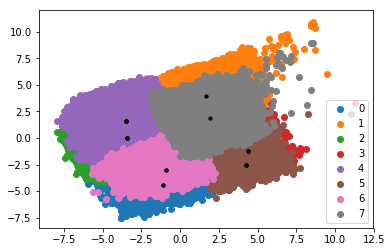

In [87]:
plot_cluster(pca_test, test_labels, kmeans.cluster_centers_)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

##### *Develop a function to measure the proportion or percentage of dataset belonging to each cluster. Following clusters should be taken care of:*
- The high nan dataset (with total null values >10%) which was dropped from analysis since step 1.1.3 should be treated as a unique cluster with cluster label: -1.
- All other cluster labels should be same as determined by kmeans cluster prediction.
- The total size of dataset should also include the size of the high nan dataset while calculating the proportion of clusters.

In [88]:
def proportion_clusters(df, df_highna, labels):
    total_length = df.shape[0] + df_highna.shape[0]
    cluster_grp = list(np.unique(labels))
    perc_per_cluster = [round(df[df['cluster']==x].shape[0]/total_length,3) for x in np.unique(labels)]
    prop_df = pd.DataFrame(list(zip(cluster_grp,perc_per_cluster)), columns=['Cluster_Group', 'Proportion'])
    prop_df.loc[len(prop_df.index)] = [-1, round(df_highna.shape[0]/total_length,2)]
    return prop_df

In [89]:
X_train_fin = pd.DataFrame(pca_train)
X_test_fin = pd.DataFrame(pca_test)
X_train_fin['cluster'] = train_labels
X_test_fin['cluster'] = test_labels
X_train_clust_prop = proportion_clusters(X_train_fin, cleaned_azdias_highna, train_labels)
X_test_clust_prop = proportion_clusters(X_test_fin, customers_cleaned_highna, test_labels)

In [90]:
X_test_clust_prop

,Cluster_Group,Proportion
0,0.0,0.019
1,1.0,0.074
2,2.0,0.353
3,3.0,0.007
4,4.0,0.135
5,5.0,0.007
6,6.0,0.013
7,7.0,0.089
8,-1.0,0.300


##### *Compare the proportion of data in each cluster for the customer data to the proportion of data in each cluster for the general population.*

Text(0.5,1,'Clusters of Training dataset')

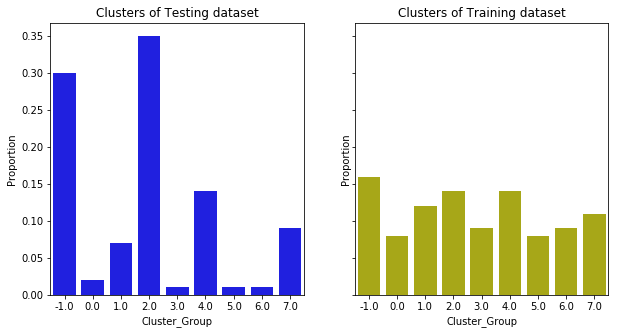

In [91]:
fig_clust, ax_clust = plt.subplots(1,2,figsize = (10,5), sharey= True)
sns.barplot(x = X_test_clust_prop['Cluster_Group'], y = np.round(X_test_clust_prop['Proportion'],2), ax = ax_clust[0],\
            color = 'b')
ax_clust[0].set_title("Clusters of Testing dataset")
sns.barplot(x = X_train_clust_prop['Cluster_Group'], y = np.round(X_train_clust_prop['Proportion'],2), ax = ax_clust[1],\
           color = 'y')
ax_clust[1].set_title("Clusters of Training dataset")

#### *Plot the difference of proportions of each cluster to get the over-represented & under-represented clusters in the customer dataset*

In [92]:
prop_diff = X_test_clust_prop.merge(X_train_clust_prop, on = "Cluster_Group", suffixes=['_test','_train'])
prop_diff["Prop_diff"] = prop_diff['Proportion_test'] - prop_diff['Proportion_train'] 
#Difference is Test - Train to find out how many data points are more/less in Test dataset than Train datase
prop_diff

,Cluster_Group,Proportion_test,Proportion_train,Prop_diff
0,0.0,0.019,0.075,-0.056
1,1.0,0.074,0.117,-0.043
2,2.0,0.353,0.140,0.213
3,3.0,0.007,0.089,-0.082
4,4.0,0.135,0.137,-0.002
5,5.0,0.007,0.075,-0.068
6,6.0,0.013,0.092,-0.079
7,7.0,0.089,0.113,-0.024
8,-1.0,0.300,0.160,0.140


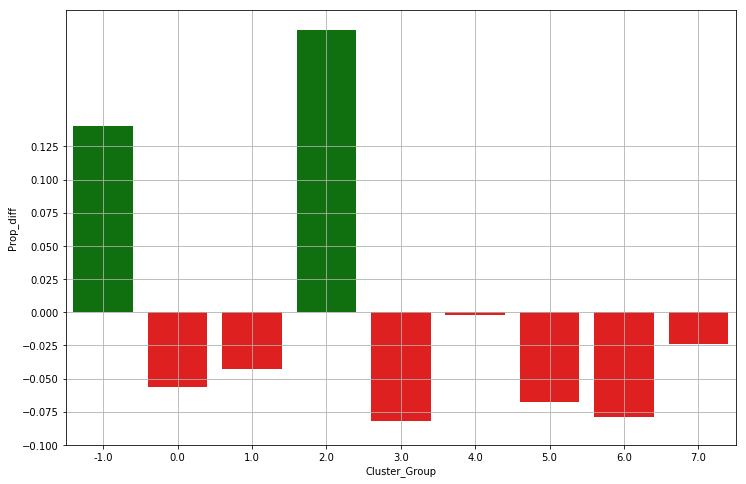

In [93]:
fig, ax = plt.subplots(figsize=(12,8))
diff_plt = sns.barplot(x = prop_diff['Cluster_Group'], y = np.round(prop_diff['Prop_diff'],3),\
            palette = sns.set_palette(['r','g']), hue = (prop_diff['Prop_diff'] > 0), dodge=False)
diff_plt.set_yticks(np.arange(-0.1,0.15,0.025))
diff_plt.grid()
diff_plt.legend_.remove()
#plt.tight_layout()

##### *Get the over-represented & under-represented clusters from the proportion difference graph*

In [94]:
prop_diff_clusts = prop_diff.loc[prop_diff['Cluster_Group'] > -1] #ignores cluster with highna 
over_rep_clust = prop_diff_clusts.loc[prop_diff_clusts['Prop_diff'].idxmax()].Cluster_Group
under_rep_clust = prop_diff_clusts.loc[prop_diff_clusts['Prop_diff'].idxmin()].Cluster_Group
print("Over-represented & Under-represented clusters respectively are:", over_rep_clust, under_rep_clust)

Over-represented & Under-represented clusters respectively are: 2.0 3.0


##### *Retrieve the over-represented cluster's original dataset*
- Get the over-represented cluster's PCA-transformed data
- Do inverse PCA transform followed by inverse scaling transform to retrieve the original over-represented cluster's data
  - ***Note:*** As total no.of pca components < actual no.of features, the inverse transformations will not retrieve exactly the same/original data as some information will still be lost.

In [101]:
print("%PCA transformed overrepresented cluster in the test dataset's results",\
      round(pca_test[np.where(test_labels==over_rep_clust)].shape[0]/pca_test.shape[0],2))
print("%PCA transformed overrepresented cluster in the train dataset's results",\
      round(pca_train[np.where(train_labels==over_rep_clust)].shape[0]/pca_train.shape[0],2))

test_overrep = scale.inverse_transform(pca_fin.inverse_transform(pca_test[np.where(test_labels==over_rep_clust)])).round()
test_overrep_df = pd.DataFrame(test_overrep,columns=scaled_test.columns)
print("Shape of overrepresented cluster's dataset after inverse transformation", test_overrep_df.shape)
test_overrep_df.head()


%PCA transformed overrepresented cluster in the test dataset's results 0.51
%PCA transformed overrepresented cluster in the train dataset's results 0.17
Shape of overrepresented cluster's dataset after inverse transformation (67561, 64)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT_ENG,DECADE_ENG,WEALTH_ENG,LIFE_STAGE_ENG
0,4.0,1.0,5.0,1.0,5.0,0.0,2.0,2.0,1.0,1.0,...,0.0,5.0,5.0,1.0,3.0,1.0,0.0,2.0,1.0,4.0
1,4.0,1.0,5.0,1.0,5.0,2.0,1.0,3.0,0.0,2.0,...,-0.0,3.0,4.0,2.0,2.0,1.0,1.0,3.0,2.0,3.0
2,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1.0,5.0,5.0,4.0,6.0,4.0,0.0,3.0,2.0,4.0
3,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,2.0,...,0.0,5.0,5.0,2.0,4.0,2.0,0.0,3.0,1.0,4.0
4,4.0,1.0,5.0,1.0,5.0,0.0,2.0,3.0,1.0,1.0,...,0.0,3.0,3.0,3.0,5.0,3.0,-0.0,2.0,2.0,4.0


##### *Retrieve the under-represented cluster's original dataset*
- Get the under-represented cluster's PCA-transformed data
- Do inverse PCA transform followed by inverse scaling transform to retrieve the original under-represented cluster's data
  - ***Note:*** As total no.of pca components < actual no.of features, the inverse transformations will not retrieve exactly the same/original data as some information will still be lost.

In [103]:
print("%PCA transformed underrepresented cluster in the test dataset's results",\
      round(pca_test[np.where(test_labels==under_rep_clust)].shape[0]/pca_test.shape[0],2))
print("%PCA transformed underrepresented cluster in the train dataset's results",\
      round(pca_train[np.where(train_labels==under_rep_clust)].shape[0]/pca_train.shape[0],2))
test_underrep = scale.inverse_transform(pca_fin.inverse_transform(pca_test[np.where(test_labels==under_rep_clust)])).round()
test_underrep_df = pd.DataFrame(test_underrep,columns=scaled_test.columns)
print("Shape of underrepresented cluster's dataset after inverse transformation", test_underrep_df.shape)
test_underrep_df.head()

%PCA transformed underrepresented cluster in the test dataset's results 0.01
%PCA transformed underrepresented cluster in the train dataset's results 0.11
Shape of underrepresented cluster's dataset after inverse transformation (1385, 64)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT_ENG,DECADE_ENG,WEALTH_ENG,LIFE_STAGE_ENG
0,2.0,2.0,2.0,2.0,4.0,2.0,1.0,5.0,-0.0,2.0,...,2.0,5.0,3.0,4.0,9.0,4.0,1.0,3.0,5.0,2.0
1,3.0,2.0,1.0,5.0,2.0,5.0,4.0,4.0,0.0,2.0,...,1.0,4.0,3.0,4.0,6.0,4.0,1.0,6.0,5.0,2.0
2,2.0,2.0,3.0,2.0,5.0,1.0,1.0,4.0,-0.0,3.0,...,1.0,3.0,3.0,4.0,8.0,5.0,1.0,3.0,5.0,2.0
3,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,-0.0,3.0,...,1.0,4.0,4.0,4.0,4.0,3.0,1.0,6.0,4.0,3.0
4,2.0,2.0,3.0,2.0,4.0,3.0,1.0,4.0,-0.0,3.0,...,2.0,3.0,2.0,4.0,8.0,4.0,1.0,4.0,5.0,2.0


##### *Retrieve the top 6 features (3 positively weighted & 3 negatively weighted)  from each of the top 4 PCA components & use them to analyze the over-represented & under-represented dataset*
- Select the over-represented/under-represented clustered dataset once they are inverse-pca & inverse-scaled transformed
- Top 4 PCA components are chosen due to their high explained variance ratio (from step2.2)
- Top 6 features are segregated in terms of positive & negative weights per PCA component 
- Use the top 6 features to plot a data distribution of the over/under-represented dataset for analysis

In [97]:
#create dict of top 3 features which are +vely & -vely weighted for each pca component
pca_top_ftrs = dict()
top = 3
pca_compt = range(0,12)
for pca_c in pca_compt:
    pos_c, neg_c = map_weights_to_feats_pca(pca_c, pca_wt)
    pca_top_ftrs[f'pca{pca_c}'] = {'pos': pos_c.iloc[:top]['pos_index'].tolist(),\
                                   'neg': neg_c.iloc[:top]['neg_index'].tolist()}
    
pca_top_df = pd.DataFrame(pca_top_ftrs).transpose()
pca_top_df.index.name = 'pca_component'
pca_top_df

,neg,pos
pca_component,,
pca0,"[MOBI_REGIO, PLZ8_ANTG1, KBA05_ANTG1]","[PLZ8_ANTG3, PLZ8_ANTG4, HH_EINKOMMEN_SCORE]"
pca1,"[SEMIO_REL, DECADE_ENG, FINANZ_SPARER]","[ALTERSKATEGORIE_GROB, FINANZ_VORSORGER, SEMIO..."
pca2,"[ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM]","[SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM]"
pca3,"[MOVEMENT_ENG, HH_EINKOMMEN_SCORE, KKK]","[GREEN_AVANTGARDE, EWDICHTE, ORTSGR_KLS9]"
pca4,"[KBA13_ANZAHL_PKW, PLZ8_HHZ, PLZ8_GBZ]","[MIN_GEBAEUDEJAHR, ARBEIT, RELAT_AB]"
pca5,"[KBA05_ANTG2, PLZ8_ANTG2, RELAT_AB]","[KBA05_ANTG4, ANZ_HAUSHALTE_AKTIV, MIN_GEBAEUD..."
pca6,"[MIN_GEBAEUDEJAHR, PLZ8_HHZ, KBA13_ANZAHL_PKW]","[ANZ_HAUSHALTE_AKTIV, KBA05_ANTG4, ANZ_HH_TITEL]"
pca7,"[SEMIO_MAT, W_KEIT_KIND_HH, KBA05_ANTG2]","[KKK, REGIOTYP, ANZ_PERSONEN]"
pca8,"[W_KEIT_KIND_HH, MIN_GEBAEUDEJAHR, RETOURTYP_B...","[ANZ_PERSONEN, ONLINE_AFFINITAET, BALLRAUM]"


##### *Develop a function that plots the data distribution of all top 6 features ( 3 positively weighted + 3 negatively weighted) per PCA component (top 4 PCA components) for the over/under-represented cluster's original retrieved data*

In [98]:
def distribution_top_ftrs(ftr_df, over_under_repdf):
    pca_counter = 0
    num_pca_compts = 4 #selecting only the top 4 pca components as their variance ratios are high
    while(pca_counter<num_pca_compts/2): #Each row 
        i=0
        fig_top, ax_top = plt.subplots(1,4, figsize=(15,4), sharey=True)
        while(i<2):
            df_pos = over_under_repdf[ftr_df.loc[f'pca{i+2*pca_counter}', 'pos']].melt()
            sns.countplot(hue=df_pos['variable'], x=df_pos['value'], ax=ax_top[2*i])
            ax_top[2*i].set_title(f'PCA{i+2*pca_counter} top +vely weighted features')
            df_neg = over_under_repdf[ftr_df.loc[f'pca{i+2*pca_counter}', 'neg']].melt()
            sns.countplot(hue=df_neg['variable'], x=df_neg['value'], ax=ax_top[2*i+1])
            ax_top[2*i+1].set_title(f'PCA{i+2*pca_counter} top -vely weighted features')
            i+=1
        plt.tight_layout()
        pca_counter+=1

##### What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?

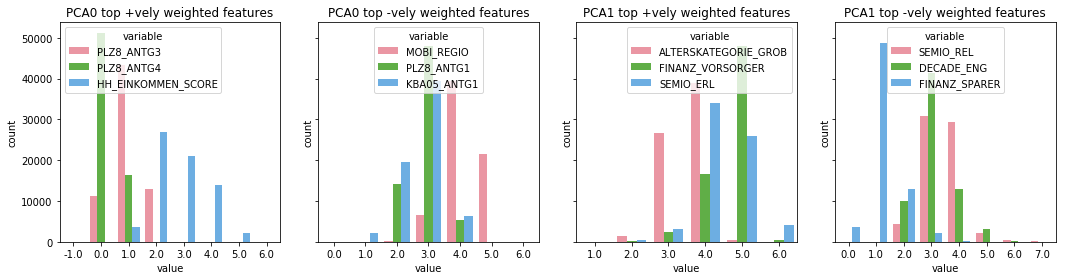

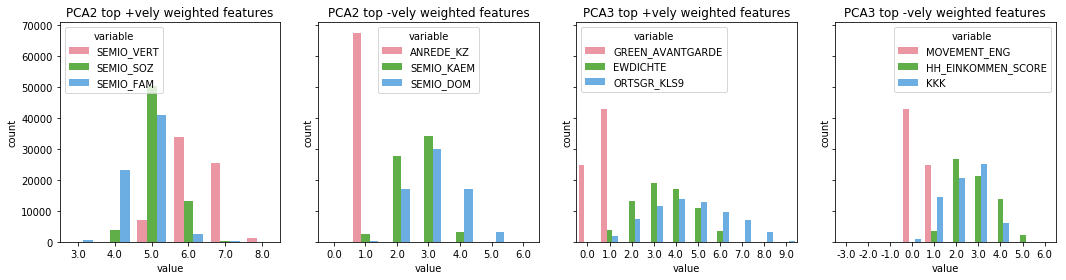

In [99]:
distribution_top_ftrs(pca_top_df,test_overrep_df)

Over-represented cluster's data distribution from the top 24 features *(describing the high data counts only for each feature)*:

**PCA0/1st PCA component:**
- PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region (1:lower share of 6-10 family homes): less densely populated
- PLZ8_ANTG4 - Number of 10+ family houses in the PLZ8 region (0: no 10+ family homes): less densely populated
- HH_EINKOMMEN_SCORE - Estimated household net income (2:very high income): high net income
- MOBI_REGIO - Movement patterns (4: low movement): Less movement
- PLZ8_ANTG1 - Number of 6-10 family houses in the PLZ8 region (3: high share of 1-2 family homes): small/nuclear families/ not so densely populated
- KBA05_ANTG1 - Number of 6-10 family houses in the microcell region (3: high share of 1-2 family homes): small/nuclear families/ not so densely populated

**PCA1/2nd PCA component:**
- ALTERSKATEGORIE_GROB - Estimated age based on given name analysis (4: > 60 years old): old people or senior citizens
- FINANZ_VORSORGER - Financial typology; be prepared (5: very low): poorly prepared financially
- SEMIO_ERL - Personality typology; event-oriented (4: average affinity): somewhat event-oriented
- SEMIO_REL - Personality typology; religious (3: high affinity): quite religious
- DECADE_ENG - Dominant decades of youth (3: 60s economic miracle/student protestors/opponents to the building of the wall): fairly old people
- FINANZ_SPARER - Financial typology; money saver (1: very high): Good money saving

**PCA2/3rd PCA component:**
- SEMIO_VERT - Personality typology; dreamful (6: very low affinity): less dreamy/quite realistic
- SEMIO_SOZ - Personality typology; socially minded (5: low affinity): not much socially minded
- SEMIO_FAM - Personality typology; family minded (5: low affinity): not much family minded
- ANREDE_KZ - Gender (1: male): Male
- SEMIO_KAEM - Personality typology; combative attitude (3: high affinity): highly combative attitude
- SEMIO_DOM - Personality typology; dominant-minded (3: high affinity): highly dominant

**PCA3/4th PCA component:**
- GREEN_AVANTGARDE - Membership in environmental sustainability as part of youth (1: member of green avantgarde): member of green avantgarde
- EWDICHTE - Density of households per square kilometer (3:  90 - 149 households per km^2): small household
- ORTSGR_KLS9 - Size of community (4:  10,001 to  20,000 inhabitants): average number of inhabitants
- MOVEMENT_ENG - Movement during person's youth (0: Avantgarde): Avantgarde
- HH_EINKOMMEN_SCORE - Estimated household net income (2:very high income): high net income
- KKK - Purchasing power in region (3: average): Average purchasing power

**Summary:** Overly-represented cluster dataset represents older generation men in their 60s, who live in less densely populated households in Avantgarde with a high net income, who are realistic but very dominant & still quite religious, good on saving money but not so well prepared financially due to average purchasing power. They are not so socially/family minded people.

##### What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?

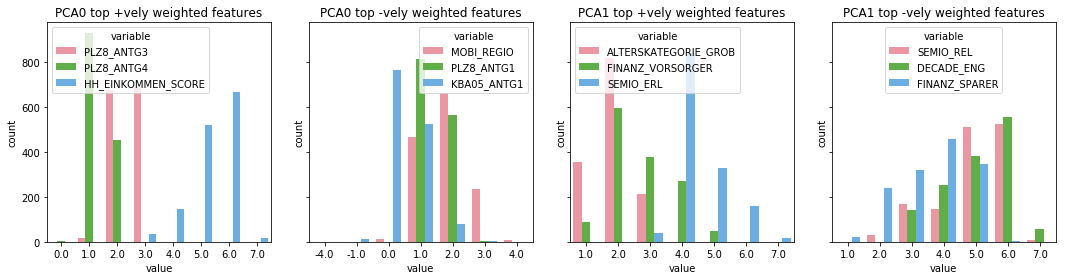

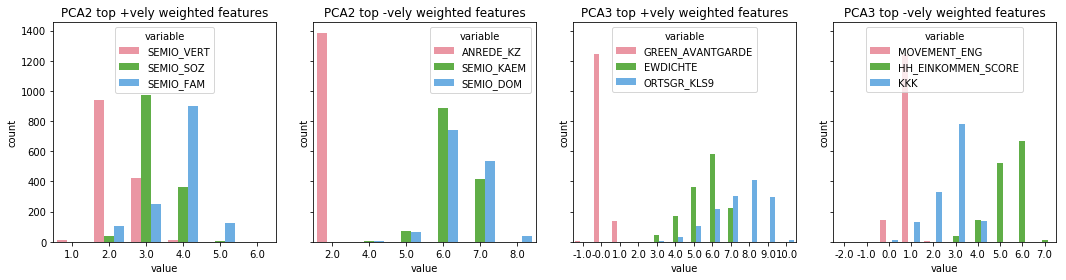

In [100]:
distribution_top_ftrs(pca_top_df,test_underrep_df)

Under-represented cluster's data distribution from the top 24 features *(describing the high data counts only for each feature)*:

**PCA0/1st PCA component:**
- PLZ8_ANTG3 - Number of 6-10 family houses in the PLZ8 region (3: high share of 6-10 family homes): highly densely populated at max upto 10 family homes
- PLZ8_ANTG4 - Number of 10+ family houses in the PLZ8 region (1: lower share of 10+ family homes): fairly densely populated 
- HH_EINKOMMEN_SCORE - Estimated household net income (6:very low income): least net income
- MOBI_REGIO - Movement patterns (2: high movement): more movement
- PLZ8_ANTG1 - Number of 6-10 family houses in the PLZ8 region (1: lower share of 1-2 family homes): not many nuclear families 
- KBA05_ANTG1 - Number of 1-2 family houses in the microcell region (0: no 1-2 family homes): no small/nuclear families

**PCA1/2nd PCA component:**
- ALTERSKATEGORIE_GROB - Estimated age based on given name analysis (2: 30-45 years old): middle-aged people
- FINANZ_VORSORGER - Financial typology; be prepared (2: high): highly prepared financially
- SEMIO_ERL - Personality typology; event-oriented (4: average affinity): somewhat event-oriented
- SEMIO_REL - Personality typology; religious (6: very low affinity): not religious
- DECADE_ENG - Dominant decades of youth (6: 90s kids): younger generation
- FINANZ_SPARER - Financial typology; money saver (4: low): poor money saver

**PCA2/3rd PCA component:**
- SEMIO_VERT - Personality typology; dreamful (2: very high affinity): very dreamy
- SEMIO_SOZ - Personality typology; socially minded (3: high affinity): very much socially minded
- SEMIO_FAM - Personality typology; family minded (4: average affinity): somewhat family minded
- ANREDE_KZ - Gender (2: female): female
- SEMIO_KAEM - Personality typology; combative attitude (6: very low affinity): not at all combative attitude
- SEMIO_DOM - Personality typology; dominant-minded (6: very low affinity): not at all dominant

**PCA3/4th PCA component:**
- GREEN_AVANTGARDE - Membership in environmental sustainability as part of youth (0: not a member of green avantgarde): not a member of green avantgarde
- EWDICHTE - Density of households per square kilometer (6:  >999 households per km^2): large households
- ORTSGR_KLS9 - Size of community (8: 300,001 to 700,000 inhabitants): large number of inhabitants
- MOVEMENT_ENG - Movement during person's youth (1: Mainstream): Mainstream
- HH_EINKOMMEN_SCORE - Estimated household net income (6:very low income): very low income
- KKK - Purchasing power in region (3: average): Average purchasing power

**Summary:** Under-represented cluster dataset represents younger generation & tech savvy women from Mainstream, who live in densely populated & large households. They are not much realistic & not religious, seem to be financially prepared but not so good in saving money & have low net income. They are not dominant & do not have a combative attitude & somewhat family minded & event-oriented. 

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

**Over-represented cluster or most popular in the customers dataset or mail-order company:**
- Summarizing the observation from the data distribution of the top positively & negatively weighted top features from the first 4 PCA components, older generation men in their 60s are very much popular among the customers. They live in less densely populated households in Avantgarde with a high net income, who are realistic but very dominant & still quite religious, good on saving money but do not seem to be so well prepared financially, probably due to average purchasing power which could mean they dont have much assets. They are not so socially/family minded people.


**Under-represented cluster or most unpopular in the customers dataset or mail-order company:**
- Summarizing the observation from the data distribution of the top positively & negatively weighted top features from the first 4 PCA components, younger generation & tech savvy women are the least popular among the customers. They live in densely populated & large households in Mainstream. They are not much realistic & not religious, seem to be financially prepared but not so good in saving money & hence have low net income. They are not dominant & do not have a combative attitude & somewhat family minded & event-oriented.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.